# Support Vector Machine Implementation
## SVM for NLP Classification of Spam Email Messages
    ## SVM (Full Implementation)
    ##     ++ Hard/Soft Margin, Linear/Polynomial/Gaussian Kernel   
    ## SVM Helper Functions + PCA + LDA (Full Implementation)
    ## Author: Samyuel Danyo
    ## Date: 8/4/2019
    ##  License: MIT License
    ##  Copyright (c) 2020 Samyuel Danyo

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import time
import cvxopt
import cvxopt.solvers
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator
np.random.seed(seed=1)
from sklearn import model_selection, metrics
import scipy.io
import warnings

## Preprocessing Functions 

In [2]:
def standardize(X):
    """ Transform the data X to have a mean of zero
        and a standard deviation of 1."""
    X_mean = np.mean(X, axis=0)
    X_var = np.std(X, axis=0)
    return (X-X_mean)/X_var

def normalize(X):
    """ Rescale the data X to ∈ [0:1]."""
    X_min = X.min()
    X_max = X.max()
    return (X - X_min)/(X_max - X_min)

def log_transform(x):
    """Transform x to natural_log(x)."""
    return np.log(x+0.1)

def binary_transform(x):
    """Transform x to binary based on sign."""
    return np.where(x>0, 1, 0)

##  Shared Helper Functions For Metrics Extraction & Cofusion Table Plot

In [3]:
def get_accuracy(targets, predictions):
    """ Helper Function for calculating the (%) accuracy of
        'predictions' compared to 'targets'."""
    return (np.abs(targets - predictions) < 1e-10 ).mean() * 100.0

def get_errors(outputs, targets):
    """ Helper Function for calculating the error rates of 'outputs' compared to 'targets'.
        Returns:
            error (NumPy Array): overall error rate.
           false_negatives_error (NumPy Array): the % of samples wrongly outputed as '0' instead of '1'.
           false_positives_error (NumPy Array): the % of samples wrongly outputed as '1' instead of '0'."""
    error_per_sample = []
    error = []
    false_negatives_error = []
    false_positives_error = []
    # Calculation per epoch.
    if(np.array(outputs).ndim == 2):
        for idx, outputs_per_par in enumerate(outputs):
            error_per_sample.append(list(np.array(outputs_per_par) - np.array(targets)))
            error.append(sum(abs(i) for i in error_per_sample[idx])/len(error_per_sample[idx])*100) 
            false_negatives_error.append(abs(sum(i for i in error_per_sample[idx] if i < 0)))/len(error_per_sample)*100
            false_positives_error.append(sum(i for i in error_per_sample[idx] if i > 0))/len(error_per_sample)*100
    # Calcualtion for a single epoch.
    elif(np.array(outputs).ndim == 1):
        error_per_sample = (list((np.array(outputs) - np.array(targets))/2))
        error = (sum(abs(i) for i in error_per_sample)/len(error_per_sample)*100) 
        false_negatives_error = (abs(sum(i for i in error_per_sample if i < 0)))/len(error_per_sample)*100
        false_positives_error = (sum(i for i in error_per_sample if i > 0))/len(error_per_sample)*100
    return error, false_negatives_error, false_positives_error

def plot_confusion_table(y_true, y_pred, title):
    """ Helper Function for displaying a confusion table of targets vs predictions."""
    # Show confusion table
    conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=None)  # Get confustion matrix
    # Plot the confusion table
    class_names = ['${:d}$'.format(x) for x in (-1, 1)]  # Binary class names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Show class labels on each axis
    ax.xaxis.tick_top()
    major_ticks = range(0,2)
    minor_ticks = [x + 0.5 for x in range(0, 2)]
    ax.xaxis.set_ticks(major_ticks, minor=False)
    ax.yaxis.set_ticks(major_ticks, minor=False)
    ax.xaxis.set_ticks(minor_ticks, minor=True)
    ax.yaxis.set_ticks(minor_ticks, minor=True)
    ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    # Set plot labels
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Predicted Label', fontsize=15)
    ax.set_ylabel('True Label', fontsize=15)
    fig.suptitle(title, y=1.03, fontsize=15)
    # Show a grid to seperate digits
    ax.grid(b=True, which=u'minor')
    # Color each grid cell according to the number classes predicted
    ax.imshow(conf_matrix, interpolation='nearest', cmap='binary')
    # Show the number of samples in each cell
    for x in range(conf_matrix.shape[0]):
        for y in range(conf_matrix.shape[1]):
            color = 'w' if x == y else 'k'
            ax.text(x, y, conf_matrix[y,x], ha="center", va="center", color=color)       
    plt.show()

## PCA Transform Class 

In [4]:
class PrincipalComponentAnalysis(object):
    """ Principal Component Analysis pattern recognition algorithm.
        PCA aims to find the directions (components) that maximize the variance of the dataset.
        PCA projects a feature space onto a subspace with minimum information loss. """
    
    def __init__(self):
        """Declare the dataset field."""
        self.Components = None
    
    def _check_eigen(self, eigen_val, eigen_vec, cov_mat):
        """ Check if the eigenvalues/eigenvectors equation Σv=λv is satisfied. """
        cov_eigen_vec = cov_mat.dot(eigen_vec)
        eigen_val_vec = eigen_val*eigen_vec
        np.testing.assert_array_almost_equal(cov_eigen_vec, eigen_val_vec,
                                             decimal=6, err_msg='Eigen Vector/Value Equation NOT Satisfied!', verbose=True)
    
    def extract(self, X):
        """ Find the components of the dataset."""
        cov_mat = np.cov(X.T)
        
        # Singular Value Decomposition (SVD)
        eigen_val, eigen_vec = np.linalg.eig(cov_mat)
        self._check_eigen(eigen_val, eigen_vec, cov_mat)
        
        # Get the components - a list of (eigenvalue, component) tuples
        self.Components = [(np.abs(eigen_val[f]), eigen_vec[:,f]) for f in range(len(eigen_val))]

        # Sort the components from high to low
        self.Components.sort(key=lambda x: x[0], reverse=True)
    
    def project(self, X, dims=1):
        """ Project the input X into <dims>-dimensional subspace, based on the
            extracted components. """
        W = self.Components[0][1].reshape(self.Components[0][1].shape[0],1)
        for dim in range(1,dims):
            W = np.hstack((W, self.Components[dim][1].reshape(self.Components[dim][1].shape[0],1)))
        Y = X.dot(W)
        return (Y, W)

## LDA Transform Class 

In [5]:
class LinearDiscriminantAnalysis(object):
    """ Linear Discriminant Analysis pattern recognition algorithm.
        LDA aims to find the directions that maximize the variance (separation)
        between classes & minimize the variance (difference) inside the classes
        (represented by maximizing the Fisher’s ratio: max( (m1-m2)**2 / (v1+v2) ).
        LDA projects an input data space onto a sub-feature space with
        minimum class-discriminatory information loss. """
    
    def __init__(self):
        """Declare the dataset field."""
        self.Directions = None
    
    def _check_eigen(self, eigen_val, eigen_vec, cov_mat):
        """ Check if the eigenvalues/eigenvectors equation Σv=λv is satisfied. """
        cov_eigen_vec = cov_mat.dot(eigen_vec)
        eigen_val_vec = eigen_val*eigen_vec
        np.testing.assert_array_almost_equal(np.abs(cov_eigen_vec), np.abs(eigen_val_vec),
                                             decimal=1, err_msg='Eigen Vector/Value Equation NOT Satisfied!', verbose=True)
    
    def extract(self, X, T):
        """ Extract the dataset (X, dependent on the class T) directions."""
        class_labs = np.unique(T)
        dim = X.shape[1]
        X_mean = np.mean(X, axis=0).reshape(dim, 1)

        # Calculate the class prior probabilities and means.
        class_priors = []
        class_means = []
        for lab in class_labs:
            X_class = X[T==lab]
            class_priors.append(len(X_class)/len(X))
            class_means.append(np.mean(X_class, axis=0).reshape(dim, 1))
  
        # Build the Within-Class Scatter Matrix (minimizing in-class variance).
        S_W = np.zeros((dim, dim))
        for idx, lab in enumerate(class_labs):
            X_class = X[T==lab]
            class_scatter = np.cov(X_class.T)
            S_W += class_scatter
            
        # Build the Between-Class Scatter Matrix (maximizing between-class separation).
        S_B = np.zeros((dim, dim))
        for idx, lab in enumerate(class_labs):
            S_B += class_priors[idx]*(class_means[idx] - X_mean).dot((class_means[idx] - X_mean).T)
        
        # Singular Value Decomposition (SVD)
        eigen_val, eigen_vec = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
        cov_mat = np.linalg.inv(S_W).dot(S_B)
        self._check_eigen(eigen_val, eigen_vec, cov_mat)
        
        # Get the directions - a list of (eigenvalue, direction) tuples
        self.Directions = [(np.abs(eigen_val[f]), eigen_vec[:,f]) for f in range(len(eigen_val))]

        # Sort the directions from high to low meaningfullness
        self.Directions.sort(key=lambda x: x[0], reverse=True)
    
    def project(self, X, dims=1):
        """ Project the input X into <dims>-dimensional subspace, based on the
            extracted directions. """
        # Buld the weight vector (column combination of the <dims> most-meaningfull directions).
        W = self.Directions[0][1].reshape(self.Directions[0][1].shape[0],1)
        for dim in range(1,dims):
            W = np.hstack((W, self.Directions[dim][1].reshape(self.Directions[dim][1].shape[0],1)))
        # Project
        Y = X.dot(W)
        return (Y, W)
    
def visualize_LDA(X, T, set_n = 'Test'):
    """ Helper Function for visualizing the feature space."""
    # Seperate the classes.
    X1 = X[T == -1]
    X2 = X[T == 1]
    dims = X.shape[1]
    
    # 2-D Data
    if dims == 2:
        plt.plot(X1[:,0], X1[:,1], 'o', markersize=7, color='blue', alpha=0.5, label='Not-SPAM')
        plt.plot(X2[:,0], X2[:,1], '^', markersize=7, color='red', alpha=0.5, label='SPAM')
        plt.xlabel('LDA_X1', fontsize=12)
        plt.ylabel('LDA_X2', fontsize=12)
        plt.legend()
        plt.title('{} Dataset LDA-Projected Into 2-D Space'.format(set_n))
        plt.show()
    # #-D Data
    elif dims == 3:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111, projection='3d')
        plt.rcParams['legend.fontsize'] = 10   
        ax.plot(X1[:,0], X1[:,1], X1[:,2], 'o', markersize=8, color='blue', alpha=0.5, label='Not-SPAM')
        ax.plot(X2[:,0], X2[:,1], X2[:,2], '^', markersize=8, alpha=0.5, color='red', label='SPAM')
        ax.set_xlabel('LDA_X1', fontsize=12)
        ax.set_ylabel('LDA_X2', fontsize=12)
        ax.set_zlabel('LDA_X3', fontsize=12)
        plt.title('{} Dataset LDA-Projected Into 3-D Space'.format(set_n))
        ax.legend()
        plt.show()

## Kernel Functions

In [6]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

## SVM Class

In [7]:
class SupportVectorMachine(object):
    """ Support Vector Machine classifier implementation.
            - Kernel trick.
            - Hard margin fit.
            - Soft margin fit.
            
        The SVM classifier aims to find the optimal hyperplane decision boundary (separation) between two classes {-1,1}.
        It approaches the task by maximizing the margin (distance) between the data and the hyperplane
        (the hyperplane can be shifted to make sure it separates the margin equally). The vectors going through
        the points between which and the hyperplane is the margin are called support vectors.
        Maximizing the margin is proven to yield the optimal separation (leads to lower probability of misclassification)
        by Cristianini and Shawe-Taylor. This leads to a optimization problem, where we try to maximize the normalized
        (geometric) margin, while keeping the absolute (functional) margin the same (=1), which leads to minimizing the weights
        (hyperplane parameters). The problem can be summed up as minimizing 1/2W.T*W, subject to d*(W.T*X+b)>=1 (d = class).
        Such primal optimization problem can be approached, using Lagrange Theorem, aiming to find the equality and inequality
        Lagrange multipliers. The optimization problem can be further remodeled, using the Kuhn-Tucker Theorem,
        to transform it from primal to dual problem, where a single parameter yields the solution to the Lagrange multipliers.
        In order to solve the problem, dual quadratic programming is required, which yields the Lagrange multipliers and hence
        the hyperplane parameters.
        The obvious problem though is that this is a linear separation. Meaning it will work for linearly separable classes.
        In order to improve the performance on overlapping data (which still is more or less linear), the soft margin is introduced.
        The concept allows for data-points to be inside the margin (basically ignoring them, when calculating the margin),
        by introducing the slack variables, which added together and scaled by ‘C’ (the cost of violating the constraints)
        are the error penalty. The optimization problem now aims not only to maximize the margin but also minimize the error.
        The third SVM concept is the kernel transform (known as the Kernel trick).
        It is based on Cover's Theorem, which states that: “Probability that classes are linearly separable increases
        when data points in input space are nonlinearly mapped to a higher dimensional feature space.”.
        In order to deal with non-linear data (which is not separable in the data space), the kernel transform K(),
        maps the input data into a feature space, before extracting the support vectors. """
    
    def __init__(self, kernel=linear_kernel, margin_type = 'hard', C=None, p=None):
        """ Initialize the classifier fields.
            Args:
                kernel      (Function): Kernel data transformation function.
                margin_type (String): The SVM margin type. Hard or Soft.
                C           (Float): The soft margin cost of violating constraints. """
        # Kernel
        self.kernel = kernel
        self.p = None
        if kernel is polynomial_kernel:
            self.p = int(p)
        # Margin
        if margin_type not in ('hard', 'soft'):
            raise ValueError('Please Choose Valid Margin Type: (hard, soft)')
        self.margin_type = margin_type
        # Cost of Violating Constraints
        self.C = None
        if margin_type is 'soft':
            self.C = float(C)
        # Hyperplane Parameters
        self.W = None
        self.b = None
        # Lagrange Multipliers
        self.a = None
        # Support Vectors
        self.SV = None
        # Support Vectors Targets
        self.SV_T = None
        
    def _get_gram_matrix(self, X):
        """ Computing the Gram Matrix of the
            transofrmed input data.
            Args:
                X (NumPy Array): Dataset Samples. """
        n_samples = X.shape[0]
        GM = np.zeros((n_samples, n_samples))
        if self.kernel is polynomial_kernel:
            for i in range(n_samples):
                for j in range(n_samples):
                    GM[i,j] = self.kernel(X[i], X[j], p=self.p)
        else:
            for i in range(n_samples):
                for j in range(n_samples):
                    GM[i,j] = self.kernel(X[i], X[j])
        return GM
    
    def _check_gram_matrix(self, GM):
        """ Check if the Gram matrix satisfies the
            Mercer Condition (if the kernel is valid). """
        eigen_val, _ = np.linalg.eig(GM)
        if np.any(eigen_val) < 0:
            raise ValueError("Kernel Does NOT Satisfy Mercer's Condition!")

    def fit(self, X, T):
        """ Find the optimal decision boundary (Hyperplane) based on the SVs.
            Args:
                X (NumPy Matrix): Input samples.
                T (NumPy Vector): Input samples targets.
            Components:
                Solve pair of primal and dual convex quadratic programs (optimisation problems).
                x,y - Optimisation Variables, Targets
                P,q - Define any quadratic objective function of x
                G,h - Define inequality constraints
                A,b - Define equality constraints
                <<Primal>>
                    minimize:   (1/2)x.TPx + q.Tx (F(w))
                    subject to: Gx <= h           (Q(w))
                                Ax = b            (H(w))
                    Generalized Lagrangian Function (L(w,a,β)):
                                F(w) + aQ(w) + βH(w)
                <<Dual>>
                    maximize:   -(1/2)(q + G.Ta + A.Ty).TP(q + G.Ta + A.Ty) - h.Ta -b.Ty (L(w,a,β))
                    subject to: q + G.Ta + A.Ty ∈ range(P)                               (∂L(w,a,β)/∂w = 0)
                                (C >=) a >= 0
                More info: <https://scaron.info/blog/quadratic-programming-in-python.html>
                           <https://cvxopt.org/userguide/coneprog.html>
          """ 
        n_samples, n_features = X.shape
        
        # Gram matrix
        GM = self._get_gram_matrix(X)
        self._check_gram_matrix(GM)
        
        # Coefficients of the Kernel Transform for the dual quadratic program problem.
        P = cvxopt.matrix(np.outer(T,T) * GM)
        # Transposed Coefficients of the input (x) (sign).
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        # Equality constraints (coefficients of the constraint equations). 
        A = cvxopt.matrix(T, (1,n_samples))
        b = cvxopt.matrix(0.0)

        # Inequality constraints (coefficients of the constraint equations).
        # Any constraints that are (>=) must be multiplied by -1 to become (<=).
        if self.C is None:
            # Hard margin (a >= 0).
            G = cvxopt.matrix(np.eye(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            # Soft margin (C >= a >= 0). Since Gx <= h does not have a lower bound, it is
            # represented by: ((-1 0), (0 -1), (1 0), (0 1)) * (a a) <= (0 0 C C)
            G_0 = (np.eye(n_samples)*-1)
            G_C = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_0, G_C)))
            h_0 = np.zeros(n_samples)
            h_C = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((h_0, h_C)))

        # Solve the QP problem.
        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Get the Lagrange multipliers.
        a = np.ravel(solution['x'])

        # Get the support vectors (they have non zero lagrange multipliers).
        sv = a > 1e-5
        sv_idx = np.arange(len(a))[sv]
        self.a = a[sv]
        self.SV = X[sv]
        self.SV_T = T[sv]
        print("{} Support Vectors Found Out of {} Data-Points".format(len(self.a), n_samples))

        # Get the optimal hyperplane parameters.
        # Intercept (based on the Discriminant Function g(x) solutions (T). b = g(x) - aTK(x,x)
        self.b = 0
        for idx, a in enumerate(self.a):
            self.b += self.SV_T[idx]
            self.b -= np.sum(self.a * self.SV_T * GM[sv_idx[idx],sv])
        # Normilise
        if len(self.a) > 1:
            self.b /= len(self.a)

        # Weight Vector W = aTSV (only for linear kernel, since non-linear depends on (y - predict samples)).
        if self.kernel is linear_kernel:
            self.W = np.zeros(n_features)
            for idx, a in enumerate(self.a):
                self.W += a * self.SV_T[idx] * self.SV[idx]

    def project(self, X):
        """ Function to project X based on the fitted SVM. """
        # Linear kernel
        if self.W is not None:
            return np.dot(X, self.W) + self.b
        # Non-linear kernel
        else:
            if self.kernel is polynomial_kernel:
                Y = np.zeros(len(X))
                for idx, x in enumerate(X):
                    Wx = 0
                    for a, SV_T, SV in zip(self.a, self.SV_T, self.SV):
                        Wx += a * SV_T * self.kernel(x, SV, p=self.p)
                    Y[idx] = Wx
            else:
                Y = np.zeros(len(X))
                for idx, x in enumerate(X):
                    Wx = 0
                    for a, SV_T, SV in zip(self.a, self.SV_T, self.SV):
                        Wx += a * SV_T * self.kernel(x, SV)
                    Y[idx] = Wx
            return Y + self.b

    def predict(self, X):
        """ Discriminative Function to return predictions based on the SVM projection. """
        return np.sign(self.project(X))

## SVM Helper Functions

In [8]:
def plot_non_lin_SVM(X_train, T_train, SVM):
    """ Visualise the 2,3-D Non-Linear Kernel SVM fit margin. """
    
    dims = X_train.shape[1]
    X1_train = X_train[T_train==1]
    X2_train = X_train[T_train==-1]
    x0 = (np.min(X_train[:,0])-1)
    y0 = (np.max(X_train[:,1])+1)
    
    if dims == 2:
        plt.plot(X1_train[:,0], X1_train[:,1], "ro", label='Class 1')
        plt.plot(X2_train[:,0], X2_train[:,1], "bo", label='Class 2')
        plt.scatter(SVM.SV[:,0], SVM.SV[:,1], s=100, c="g")
    
        X1, X2 = np.meshgrid(np.linspace(x0,y0,50), np.linspace(x0,y0,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Y = SVM.project(X).reshape(X1.shape)
        plt.contour(X1, X2, Y, [0.0], colors='k', linewidths=1, origin='lower')
        plt.contour(X1, X2, Y + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        plt.contour(X1, X2, Y - 1, [0.0], colors='grey', linewidths=1, origin='lower')
        
        plt.xlabel('X1', fontsize=15)
        plt.ylabel('X2', fontsize=15)
        plt.legend()
        plt.title('Non-Linear 2-D SVM Fit')
        plt.axis("tight")
        plt.show()

def show_results_SVM(svm, X, accuracy_train, accuracy_test, false_neg_train,
                     false_pos_train, false_neg_test, false_pos_test, fit_time):
    """ Helper Function for displaying the fit profiling.
        Args:
            svm        (SupportVectorMachine Object): SVM Fitted Classifier.
            X          (NumPy Matrix): Dataset (usually test).
            accuracy   (Float): Prediction Accuracy."""
    dims = X.shape[1]
    #DISPLAY DATA
    m, s = divmod(fit_time, 60)
    h, m = divmod(m, 60)
    print("==============================================================================================")
    print("OVERALL TIME FOR FIT: {}h:{}m:{:.5f}s".format(h,m,s))
    print("DATA DIMENSIONALITY: {}-D".format(dims))
    print("TRAIN ACCURACY: {:.2f}% | TRAIN ERROR RATE: {:.2f}%".format(accuracy_train, 100-accuracy_train))
    print("  TRAIN FALSE NEGATIVES: {:.2f}% | TRAIN FALSE POSTIVES: {:.2f}%".format(false_neg_train, false_pos_train))
    print("TEST ACCURACY: {:.2f}% | TEST ERROR RATE: {:.2f}%".format(accuracy_test, 100-accuracy_test))
    print("  TEST FALSE NEGATIVES: {:.2f}% | TEST FALSE POSTIVES: {:.2f}%".format(false_neg_test, false_pos_test))
    print("==============================================================================================")
    
def fit_SVM(X_train, T_train, X_test, T_test, kernel = linear_kernel,
            margin_type = 'hard', C=None, p = None, transform = 'None', pp_dims = 3, plot_lda = False):
    """ A Wrapper Function which encapsulates SVM fitting, testing, data gathering & data display.
        Args:
            X (NumPy Matrix): Dataset samples.
            T (NumPy Vector): Dataset targets."""
    
    start_time = time.time()
    
    # INITIALISE THE SVM classifier
    SVM = SupportVectorMachine(kernel=kernel, margin_type=margin_type, C=C, p=p)
    print("\n######################################################################################")
    print("SVM FIT | KERNEL={} | p={}".format(SVM.kernel, SVM.p))
    print("        | MARGIN_TYPE={} | C={} | TRANSFORM={}-D {}".format(SVM.margin_type, SVM.C, pp_dims, transform))
    print("######################################################################################")
    
    # Copy the sets. If transform is applied, we do not want to change the original sets.
    X_train_in = np.copy(X_train)
    X_test_in = np.copy(X_test)
    
    # TANSFORM DATASPACE -> NEW FEATURE SPACE
    if transform is "PCA":
        # INITIALISE THE PCA module
        PCA = PrincipalComponentAnalysis()

        # EXTRACT THE TRAIN DATASET COMPONENTS
        PCA.extract(X_train)
        # PROJECT X INTO pp_dims-D SPACE
        # Train
        (X_train_in, _) = PCA.project(X_train, pp_dims)
        X_train_in = X_train_in.astype(float)
        # Test
        (X_test_in, _) = PCA.project(X_test, pp_dims)
        X_test_in = X_test_in.astype(float)
    
    elif transform is "LDA":
        # INITIALISE THE LDA module
        LDA = LinearDiscriminantAnalysis()
    
        # EXTRACT THE TRAIN DATASET DIRECTIONS
        LDA.extract(X_train, T_train)
        # PROJECT X INTO pp_dims-D SPACE
        # Train
        (X_train_in, _) = LDA.project(X_train, pp_dims)
        X_train_in = X_train_in.astype(float)
        if plot_lda:
            visualize_LDA(X_train_in, T_train, set_n = 'Train')
        # Test
        (X_test_in, _) = LDA.project(X_test, pp_dims)
        X_test_in = X_test_in.astype(float)
        if plot_lda:
            visualize_LDA(X_test_in, T_test, set_n = 'Test')
    
    elif transform is "None":
        print("No Transform Will Be Applied.")
    else:
        warnings.warn("Invalid Transform Selected. No Transform Will Be Performed!")
    
    # CHECK IF THE DATASET IS LABELED [-1,1]
    class_labs = np.unique(T_train)
    if len(class_labs) != 2:
        raise ValueError('Please Pass 2-label Dataset For SVM Fitting.')
    elif class_labs is not np.array([-1, 1]):
        T_train_class = np.copy(T_train)
        T_train_class[T_train==class_labs[0]] = -1
        T_train_class[T_train==class_labs[1]] = 1
        T_test_class = np.copy(T_test)
        T_test_class[T_test==class_labs[0]] = -1
        T_test_class[T_test==class_labs[1]] = 1
        
        # FIT SVM
        SVM.fit(X_train_in, T_train_class)
    
        # PREDICT
        Y = SVM.predict(X_train_in)
        accuracy_train = get_accuracy(T_train_class, Y)
        _, false_neg_error_train, false_pos_error_train = get_errors(Y, T_train_class)
        Y = SVM.predict(X_test_in)
        accuracy_test = get_accuracy(T_test_class, Y)
        _, false_neg_error_test, false_pos_error_test = get_errors(Y, T_test_class)
    else:
        # FIT SVM
        SVM.fit(X_train_in, T_train)
    
        # PREDICT
        Y = SVM.predict(X_train_in)
        accuracy_train = get_accuracy(T_train, Y)
        _, false_neg_error_train, false_pos_error_train = get_errors(Y, T_train)
        Y = SVM.predict(X_test_in)
        accuracy_test = get_accuracy(T_test, Y)
        _, false_neg_error_test, false_pos_error_test = get_errors(Y, T_test)
    
    fit_time = time.time() - start_time
    
    # VISUALIZE SOLUTION
    if kernel is not linear_kernel:
        plot_non_lin_SVM(X_train_in, T_train, SVM)
    plot_confusion_table(T_test, Y, "{} Margin {} SVM Confusion Table".format(margin_type, kernel))
    
    # DISPLAY FIT DATA
    show_results_SVM(SVM, X_train_in, accuracy_train, accuracy_test, false_neg_error_train,
                     false_pos_error_train, false_neg_error_test, false_pos_error_test, fit_time)

## Dataset Preprocessing

In [9]:
# Get the Dataset into NumPy arrays.
EMAIL_TRAIN_DICT = scipy.io.loadmat('train.mat')
X_TRAIN = np.array(EMAIL_TRAIN_DICT["train_data"]).T
T_TRAIN = np.array(EMAIL_TRAIN_DICT["train_label"])
T_TRAIN = T_TRAIN.reshape(T_TRAIN.shape[0])

EMAIL_TEST_DICT = scipy.io.loadmat('test.mat')
X_TEST = np.array(EMAIL_TEST_DICT["test_data"]).T
T_TEST = np.array(EMAIL_TEST_DICT["test_label"])
T_TEST = T_TEST.reshape(T_TEST.shape[0])

EMAIL_DATASET = np.column_stack((np.vstack((X_TRAIN, X_TEST)),np.hstack((T_TRAIN, T_TEST))))
print(">>>>>> EMAIL DATASET FEATURE SPACE <<<<<<")
print(">>> FULL <<<")
print(np.array(EMAIL_DATASET).shape)
print(">>> TRAIN <<<")
print(X_TRAIN.shape)
print(T_TRAIN.shape)
print(">>> TEST <<<")
print(X_TEST.shape)
print(T_TEST.shape)

>>>>>> EMAIL DATASET FEATURE SPACE <<<<<<
>>> FULL <<<
(3536, 58)
>>> TRAIN <<<
(2000, 57)
(2000,)
>>> TEST <<<
(1536, 57)
(1536,)


In [10]:
# Preprocess the data
X_TRAIN_BNY = binary_transform(X_TRAIN)
X_TEST_BNY = binary_transform(X_TEST)

X_TRAIN_LOG = log_transform(X_TRAIN)
X_TEST_LOG = log_transform(X_TEST)

X_TRAIN_STD = standardize(X_TRAIN)
X_TEST_STD = standardize(X_TEST)

## Train & Test | Hard Margin SVM With Linear Kernel

In [11]:
# CONTROL HYPERPARAMETERS HARD MARGIN LINEAR KERNEL 
X_train_list = [X_TRAIN_BNY, X_TRAIN_STD, X_TRAIN_LOG]
X_train_list_names = ['X_TRAIN_BNY', 'X_TRAIN_STD', 'X_TRAIN_LOG']
X_test_list = [X_TEST_BNY, X_TEST_STD, X_TEST_LOG]
Transform_list = ['None', 'PCA', 'LDA']
Dims_list = [57, 15, 2]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_BNY
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function linear_kernel at 0x0000000009705EA0> | p=None
        | MARGIN_TYPE=hard | C=None | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
2000 Support Vectors Found Out of 2000 Data-Points


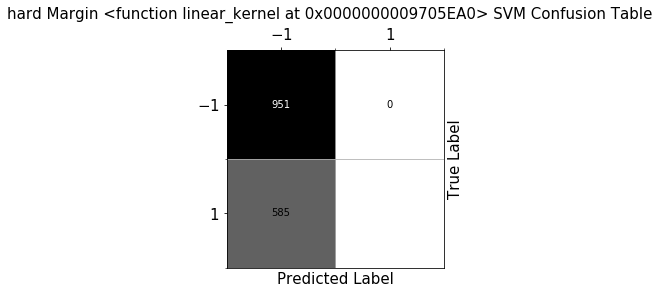

OVERALL TIME FOR FIT: 0.0h:0.0m:30.88477s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 59.60% | TRAIN ERROR RATE: 40.40%
  TRAIN FALSE NEGATIVES: 40.40% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 61.91% | TEST ERROR RATE: 38.09%
  TEST FALSE NEGATIVES: 38.09% | TEST FALSE POSTIVES: 0.00%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_STD
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function linear_kernel at 0x0000000009705EA0> | p=None
        | MARGIN_TYPE=hard | C=None | TRANSFORM=15-D PCA
######################################################################################
2000 Support Vectors Found Out of 2000 Data-Points


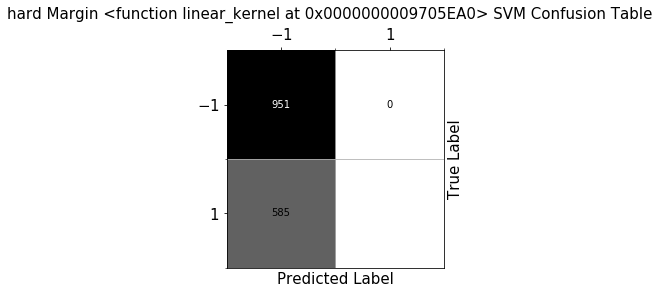

OVERALL TIME FOR FIT: 0.0h:0.0m:22.79830s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 59.60% | TRAIN ERROR RATE: 40.40%
  TRAIN FALSE NEGATIVES: 40.40% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 61.91% | TEST ERROR RATE: 38.09%
  TEST FALSE NEGATIVES: 38.09% | TEST FALSE POSTIVES: 0.00%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_LOG
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function linear_kernel at 0x0000000009705EA0> | p=None
        | MARGIN_TYPE=hard | C=None | TRANSFORM=2-D LDA
######################################################################################


D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:93: ComplexWarning: Casting complex values to real discards the imaginary part


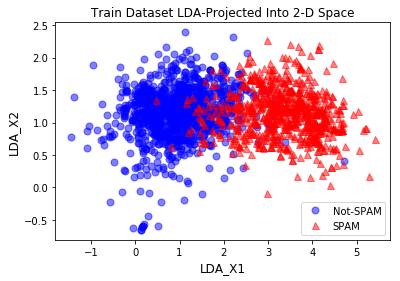

D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:98: ComplexWarning: Casting complex values to real discards the imaginary part


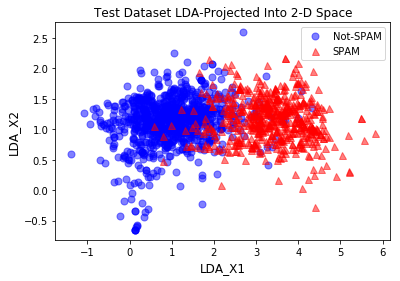

2000 Support Vectors Found Out of 2000 Data-Points


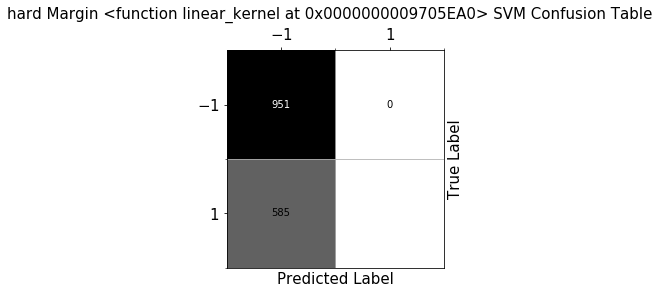

OVERALL TIME FOR FIT: 0.0h:0.0m:22.45828s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 59.60% | TRAIN ERROR RATE: 40.40%
  TRAIN FALSE NEGATIVES: 40.40% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 61.91% | TEST ERROR RATE: 38.09%
  TEST FALSE NEGATIVES: 38.09% | TEST FALSE POSTIVES: 0.00%


In [12]:
# RUN HARD MARGIN LINEAR KERNEL EXPERIMENT
for idx, (X_train, X_test, transform, dims) in enumerate(zip(X_train_list, X_test_list, Transform_list, Dims_list)):
    print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print("X_train = {}".format(X_train_list_names[idx]))
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    fit_SVM(X_train, T_TRAIN.astype(float), X_test, T_TEST.astype(float),
            kernel = linear_kernel, margin_type = 'hard', transform = transform, pp_dims = dims, plot_lda = True)

## Train & Test | Hard Margin SVM With Polynomial Kernel


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_STD | NO PCA TRANSFORM
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x0000000009705F28> | p=3
        | MARGIN_TYPE=hard | C=None | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
1996 Support Vectors Found Out of 2000 Data-Points


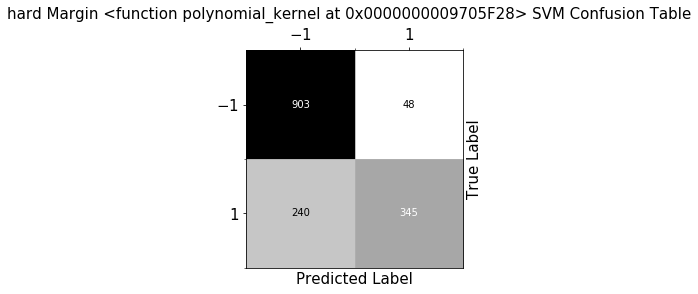

OVERALL TIME FOR FIT: 0.0h:1.0m:8.54792s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 83.75% | TRAIN ERROR RATE: 16.25%
  TRAIN FALSE NEGATIVES: 16.25% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 81.25% | TEST ERROR RATE: 18.75%
  TEST FALSE NEGATIVES: 15.62% | TEST FALSE POSTIVES: 3.12%


In [13]:
print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print("X_train = X_TRAIN_STD | NO PCA TRANSFORM")
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
fit_SVM(X_TRAIN_STD, T_TRAIN.astype(float), X_TEST_STD, T_TEST.astype(float),
                kernel = polynomial_kernel, margin_type = 'hard', p=3, transform = 'None', pp_dims = 57)


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_LOG | NO LDA TRANSFORM
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x0000000009705F28> | p=3
        | MARGIN_TYPE=hard | C=None | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
226 Support Vectors Found Out of 2000 Data-Points


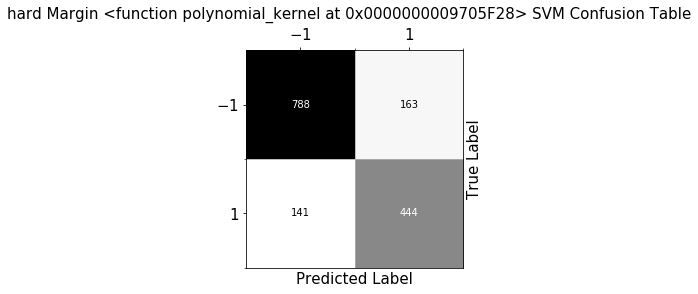

OVERALL TIME FOR FIT: 0.0h:0.0m:41.07735s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 82.05% | TRAIN ERROR RATE: 17.95%
  TRAIN FALSE NEGATIVES: 8.70% | TRAIN FALSE POSTIVES: 9.25%
TEST ACCURACY: 80.21% | TEST ERROR RATE: 19.79%
  TEST FALSE NEGATIVES: 9.18% | TEST FALSE POSTIVES: 10.61%


In [14]:
print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print("X_train = X_TRAIN_LOG | NO LDA TRANSFORM")
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
fit_SVM(X_TRAIN_LOG, T_TRAIN.astype(float), X_TEST_LOG, T_TEST.astype(float),
                kernel = polynomial_kernel, margin_type = 'hard', p=3, transform = 'None', pp_dims = 57)

In [148]:
# CONTROL HYPERPARAMETERS HARD MARGIN POLYNOMIAL KERNEL
X_train_list = [X_TRAIN_BNY, X_TRAIN_STD, X_TRAIN_LOG]
X_train_list_names = ['X_TRAIN_BNY', 'X_TRAIN_STD', 'X_TRAIN_LOG']
X_test_list = [X_TEST_BNY, X_TEST_STD, X_TEST_LOG]
Transform_list = ['None', 'PCA', 'LDA']
Dims_list = [57, 15, 2]
P_list = [2,3,4,5]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_BNY
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=hard | C=None | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
1229 Support Vectors Found Out of 2000 Data-Points


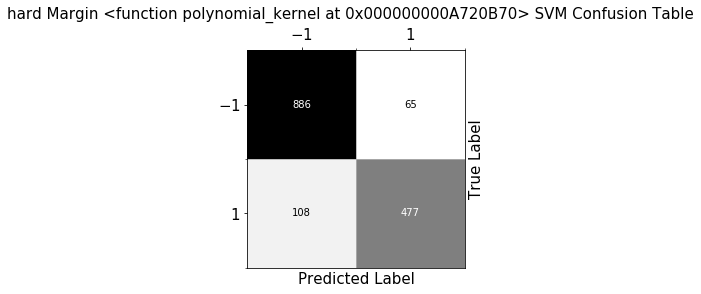

OVERALL TIME FOR FIT: 0.0h:0.0m:39.35625s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 87.65% | TRAIN ERROR RATE: 12.35%
  TRAIN FALSE NEGATIVES: 7.95% | TRAIN FALSE POSTIVES: 4.40%
TEST ACCURACY: 88.74% | TEST ERROR RATE: 11.26%
  TEST FALSE NEGATIVES: 7.03% | TEST FALSE POSTIVES: 4.23%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=hard | C=None | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
1260 Support Vectors Found Out of 2000 Data-Points


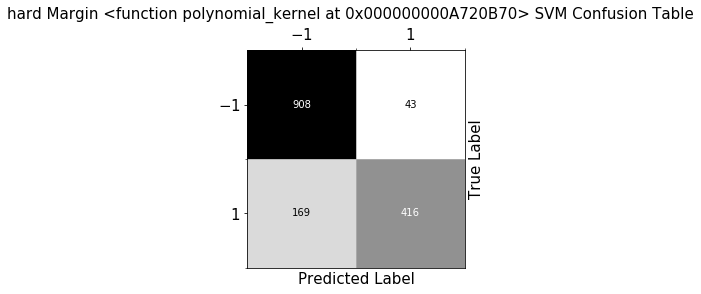

OVERALL TIME FOR FIT: 0.0h:0.0m:32.97789s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 85.15% | TRAIN ERROR RATE: 14.85%
  TRAIN FALSE NEGATIVES: 12.25% | TRAIN FALSE POSTIVES: 2.60%
TEST ACCURACY: 86.20% | TEST ERROR RATE: 13.80%
  TEST FALSE NEGATIVES: 11.00% | TEST FALSE POSTIVES: 2.80%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=hard | C=None | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
1184 Support Vectors Found Out of 2000 Data-Points


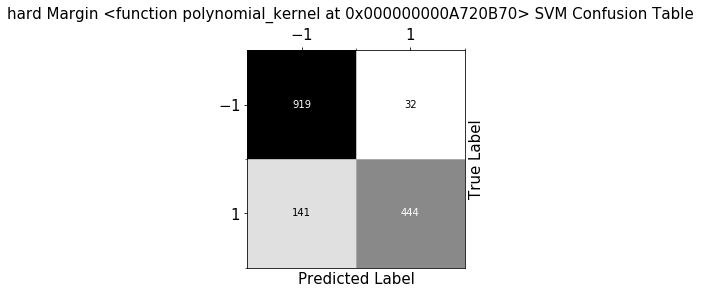

OVERALL TIME FOR FIT: 0.0h:0.0m:34.77599s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 88.25% | TRAIN ERROR RATE: 11.75%
  TRAIN FALSE NEGATIVES: 10.10% | TRAIN FALSE POSTIVES: 1.65%
TEST ACCURACY: 88.74% | TEST ERROR RATE: 11.26%
  TEST FALSE NEGATIVES: 9.18% | TEST FALSE POSTIVES: 2.08%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=hard | C=None | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
820 Support Vectors Found Out of 2000 Data-Points


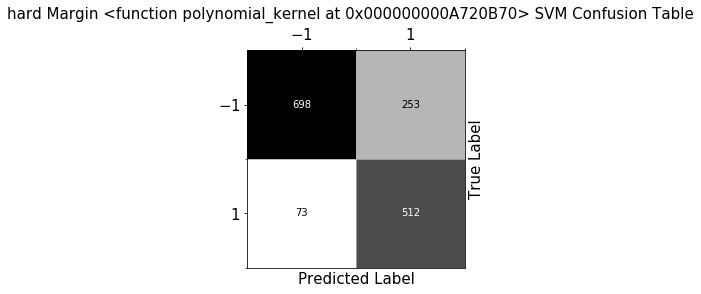

OVERALL TIME FOR FIT: 0.0h:0.0m:41.51737s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 79.35% | TRAIN ERROR RATE: 20.65%
  TRAIN FALSE NEGATIVES: 4.40% | TRAIN FALSE POSTIVES: 16.25%
TEST ACCURACY: 78.78% | TEST ERROR RATE: 21.22%
  TEST FALSE NEGATIVES: 4.75% | TEST FALSE POSTIVES: 16.47%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_STD
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=hard | C=None | TRANSFORM=15-D PCA
######################################################################################
2000 Support Vectors Found Out of 2000 Data-Points


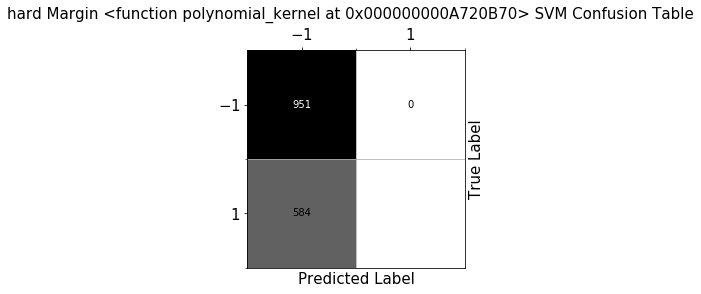

OVERALL TIME FOR FIT: 0.0h:0.0m:53.95209s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 59.60% | TRAIN ERROR RATE: 40.40%
  TRAIN FALSE NEGATIVES: 40.40% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 61.98% | TEST ERROR RATE: 38.02%
  TEST FALSE NEGATIVES: 38.02% | TEST FALSE POSTIVES: 0.00%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=hard | C=None | TRANSFORM=15-D PCA
######################################################################################
2000 Support Vectors Found Out of 2000 Data-Points


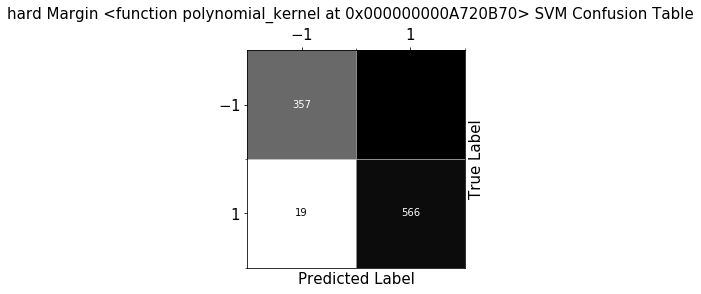

OVERALL TIME FOR FIT: 0.0h:1.0m:54.35354s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 60.25% | TRAIN ERROR RATE: 39.75%
  TRAIN FALSE NEGATIVES: 0.00% | TRAIN FALSE POSTIVES: 39.75%
TEST ACCURACY: 60.09% | TEST ERROR RATE: 39.91%
  TEST FALSE NEGATIVES: 1.24% | TEST FALSE POSTIVES: 38.67%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=hard | C=None | TRANSFORM=15-D PCA
######################################################################################
1991 Support Vectors Found Out of 2000 Data-Points


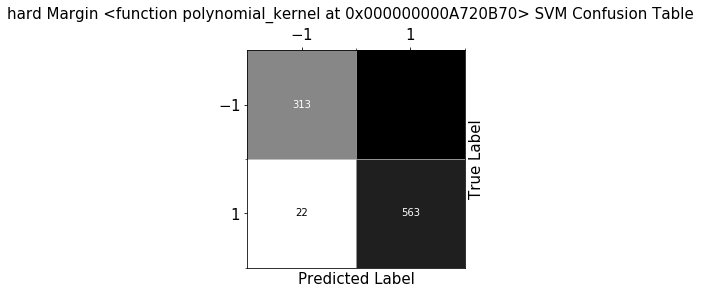

OVERALL TIME FOR FIT: 0.0h:1.0m:49.10124s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 60.00% | TRAIN ERROR RATE: 40.00%
  TRAIN FALSE NEGATIVES: 0.00% | TRAIN FALSE POSTIVES: 40.00%
TEST ACCURACY: 57.03% | TEST ERROR RATE: 42.97%
  TEST FALSE NEGATIVES: 1.43% | TEST FALSE POSTIVES: 41.54%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=hard | C=None | TRANSFORM=15-D PCA
######################################################################################
1956 Support Vectors Found Out of 2000 Data-Points


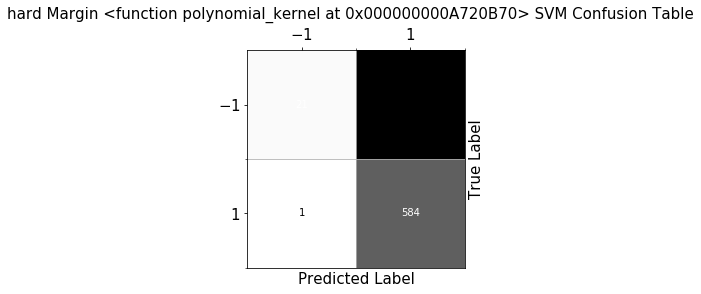

OVERALL TIME FOR FIT: 0.0h:1.0m:31.69624s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 41.70% | TRAIN ERROR RATE: 58.30%
  TRAIN FALSE NEGATIVES: 0.00% | TRAIN FALSE POSTIVES: 58.30%
TEST ACCURACY: 39.39% | TEST ERROR RATE: 60.61%
  TEST FALSE NEGATIVES: 0.07% | TEST FALSE POSTIVES: 60.55%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_LOG
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=hard | C=None | TRANSFORM=2-D LDA
######################################################################################


D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:93: ComplexWarning: Casting complex values to real discards the imaginary part
D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:98: ComplexWarning: Casting complex values to real discards the imaginary part


2000 Support Vectors Found Out of 2000 Data-Points


D:\Work\Anaconda\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


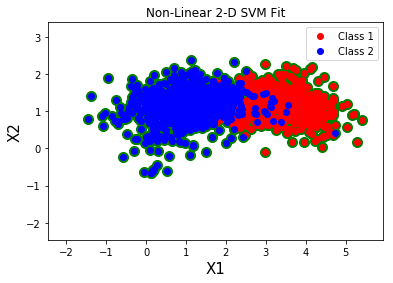

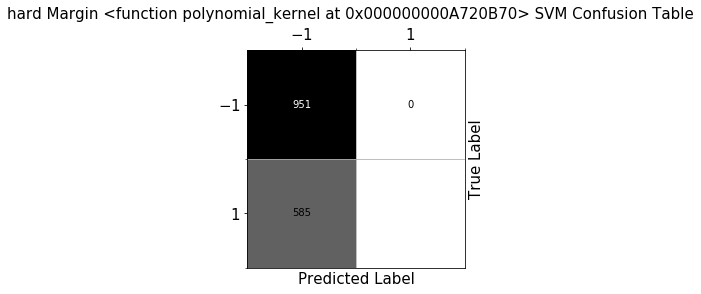

OVERALL TIME FOR FIT: 0.0h:0.0m:59.53241s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 59.60% | TRAIN ERROR RATE: 40.40%
  TRAIN FALSE NEGATIVES: 40.40% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 61.91% | TEST ERROR RATE: 38.09%
  TEST FALSE NEGATIVES: 38.09% | TEST FALSE POSTIVES: 0.00%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=hard | C=None | TRANSFORM=2-D LDA
######################################################################################
2000 Support Vectors Found Out of 2000 Data-Points


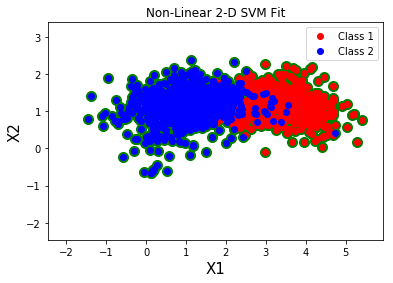

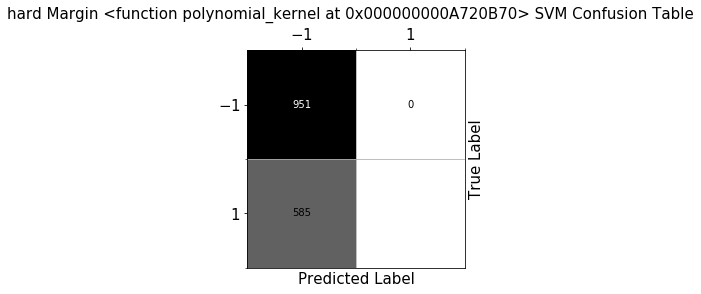

OVERALL TIME FOR FIT: 0.0h:0.0m:54.88314s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 59.60% | TRAIN ERROR RATE: 40.40%
  TRAIN FALSE NEGATIVES: 40.40% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 61.91% | TEST ERROR RATE: 38.09%
  TEST FALSE NEGATIVES: 38.09% | TEST FALSE POSTIVES: 0.00%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=hard | C=None | TRANSFORM=2-D LDA
######################################################################################
2000 Support Vectors Found Out of 2000 Data-Points


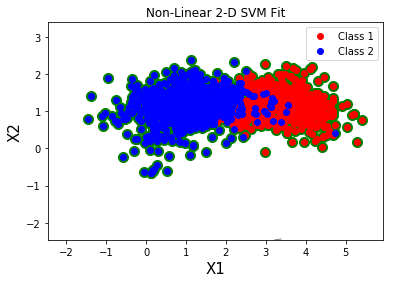

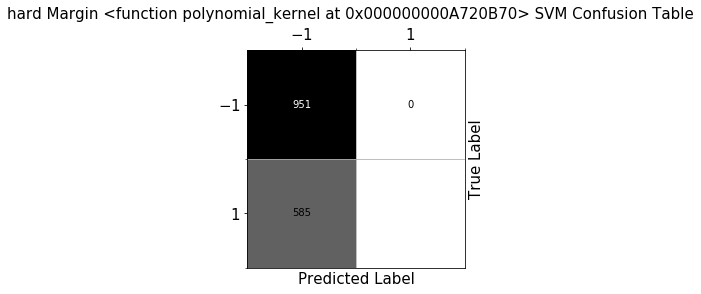

OVERALL TIME FOR FIT: 0.0h:0.0m:53.29605s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 59.60% | TRAIN ERROR RATE: 40.40%
  TRAIN FALSE NEGATIVES: 40.40% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 61.91% | TEST ERROR RATE: 38.09%
  TEST FALSE NEGATIVES: 38.09% | TEST FALSE POSTIVES: 0.00%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=hard | C=None | TRANSFORM=2-D LDA
######################################################################################
2000 Support Vectors Found Out of 2000 Data-Points


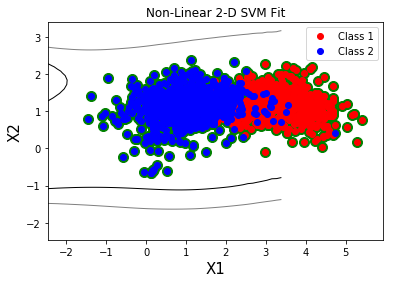

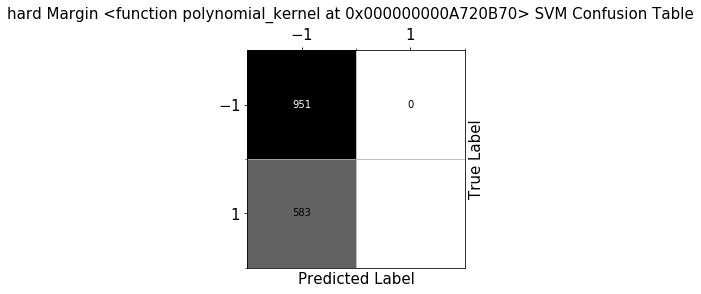

OVERALL TIME FOR FIT: 0.0h:0.0m:54.27310s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 59.80% | TRAIN ERROR RATE: 40.20%
  TRAIN FALSE NEGATIVES: 40.20% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 62.04% | TEST ERROR RATE: 37.96%
  TEST FALSE NEGATIVES: 37.96% | TEST FALSE POSTIVES: 0.00%


In [149]:
# RUN HARD MARGIN POLYNOMIAL KERNEL EXPERIMENT
for idx, (X_train, X_test, transform, dims) in enumerate(zip(X_train_list, X_test_list, Transform_list, Dims_list)):
    print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print("X_train = {}".format(X_train_list_names[idx]))
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    for p in P_list:
        fit_SVM(X_train, T_TRAIN.astype(float), X_test, T_TEST.astype(float),
                kernel = polynomial_kernel, margin_type = 'hard', p=p, transform = transform, pp_dims = dims)

## Train & Test | Soft Margin SVM With Polynomial Kernel


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_STD | NO PCA TRANSFORM
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
417 Support Vectors Found Out of 2000 Data-Points


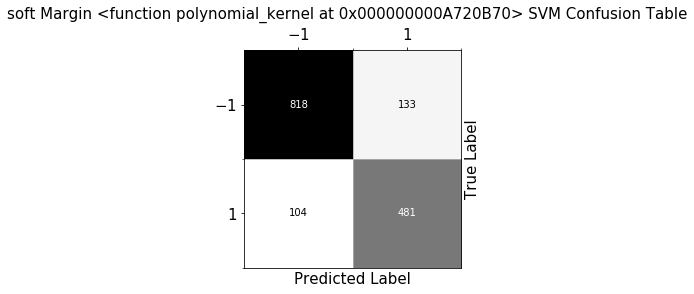

OVERALL TIME FOR FIT: 0.0h:0.0m:44.31153s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 94.30% | TRAIN ERROR RATE: 5.70%
  TRAIN FALSE NEGATIVES: 3.25% | TRAIN FALSE POSTIVES: 2.45%
TEST ACCURACY: 84.57% | TEST ERROR RATE: 15.43%
  TEST FALSE NEGATIVES: 6.77% | TEST FALSE POSTIVES: 8.66%


In [164]:
print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print("X_train = X_TRAIN_STD | NO PCA TRANSFORM")
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
fit_SVM(X_TRAIN_STD, T_TRAIN.astype(float), X_TEST_STD, T_TEST.astype(float),
                    kernel = polynomial_kernel, margin_type = 'soft', C=0.6, p=3, transform = 'None', pp_dims = 57)


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_STD | NO LDA TRANSFORM
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
198 Support Vectors Found Out of 2000 Data-Points


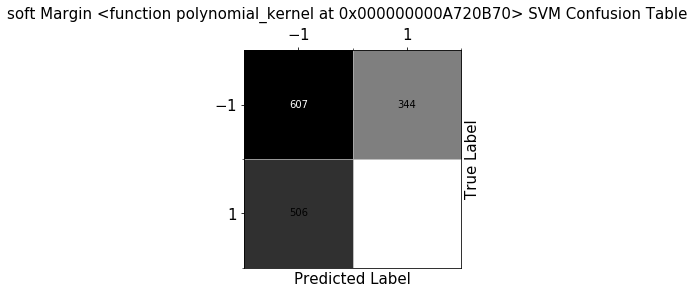

OVERALL TIME FOR FIT: 0.0h:0.0m:39.98229s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 44.45% | TRAIN ERROR RATE: 55.55%
  TRAIN FALSE NEGATIVES: 33.05% | TRAIN FALSE POSTIVES: 22.50%
TEST ACCURACY: 44.66% | TEST ERROR RATE: 55.34%
  TEST FALSE NEGATIVES: 32.94% | TEST FALSE POSTIVES: 22.40%


In [165]:
print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print("X_train = X_TRAIN_STD | NO LDA TRANSFORM")
print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
fit_SVM(X_TRAIN_LOG, T_TRAIN.astype(float), X_TEST_LOG, T_TEST.astype(float),
                    kernel = polynomial_kernel, margin_type = 'soft', C=0.6, p=3, transform = 'None', pp_dims = 57)

In [150]:
# CONTROL HYPERPARAMETERS SOFT MARGIN POLYNOMIAL KERNEL
X_train_list = [X_TRAIN_BNY, X_TRAIN_STD, X_TRAIN_LOG]
X_train_list_names = ['X_TRAIN_BNY', 'X_TRAIN_STD', 'X_TRAIN_LOG']
X_test_list = [X_TEST_BNY, X_TEST_STD, X_TEST_LOG]
Transform_list = ['None', 'PCA', 'LDA']
Dims_list = [57, 15, 2]
P_list = [1,2,3,4,5]
C_list = [0.1, 0.6, 1.1, 2.1]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_BNY
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
508 Support Vectors Found Out of 2000 Data-Points


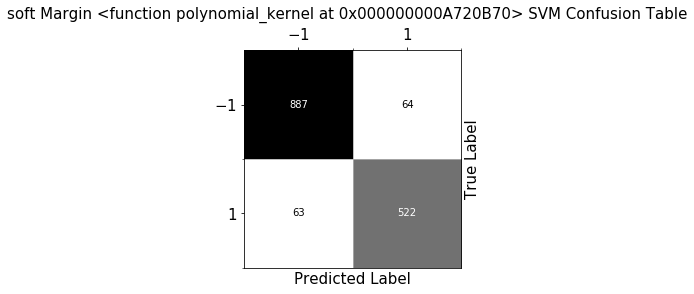

OVERALL TIME FOR FIT: 0.0h:0.0m:48.28876s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 93.15% | TRAIN ERROR RATE: 6.85%
  TRAIN FALSE NEGATIVES: 4.05% | TRAIN FALSE POSTIVES: 2.80%
TEST ACCURACY: 91.73% | TEST ERROR RATE: 8.27%
  TEST FALSE NEGATIVES: 4.10% | TEST FALSE POSTIVES: 4.17%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
419 Support Vectors Found Out of 2000 Data-Points


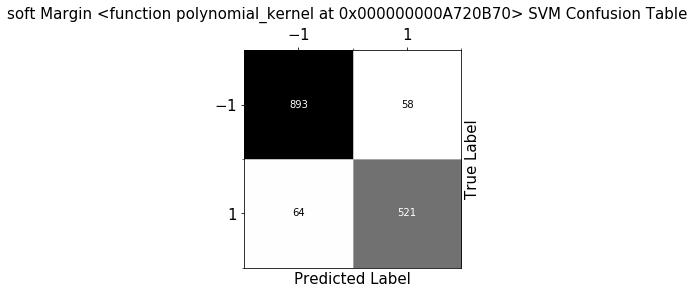

OVERALL TIME FOR FIT: 0.0h:0.0m:36.21107s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 93.45% | TRAIN ERROR RATE: 6.55%
  TRAIN FALSE NEGATIVES: 3.80% | TRAIN FALSE POSTIVES: 2.75%
TEST ACCURACY: 92.06% | TEST ERROR RATE: 7.94%
  TEST FALSE NEGATIVES: 4.17% | TEST FALSE POSTIVES: 3.78%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
398 Support Vectors Found Out of 2000 Data-Points


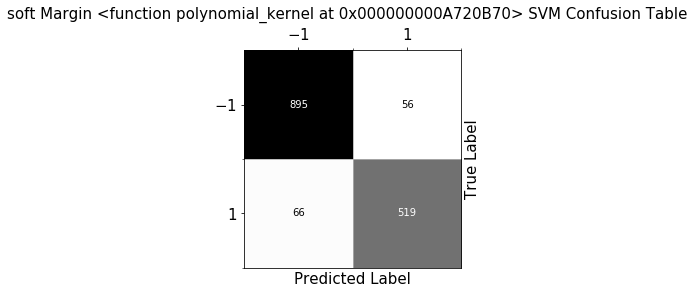

OVERALL TIME FOR FIT: 0.0h:0.0m:32.53586s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 93.50% | TRAIN ERROR RATE: 6.50%
  TRAIN FALSE NEGATIVES: 3.75% | TRAIN FALSE POSTIVES: 2.75%
TEST ACCURACY: 92.06% | TEST ERROR RATE: 7.94%
  TEST FALSE NEGATIVES: 4.30% | TEST FALSE POSTIVES: 3.65%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
383 Support Vectors Found Out of 2000 Data-Points


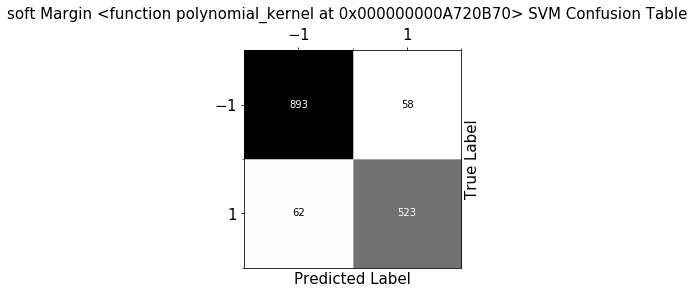

OVERALL TIME FOR FIT: 0.0h:0.0m:33.97094s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 93.45% | TRAIN ERROR RATE: 6.55%
  TRAIN FALSE NEGATIVES: 3.85% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 92.19% | TEST ERROR RATE: 7.81%
  TEST FALSE NEGATIVES: 4.04% | TEST FALSE POSTIVES: 3.78%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
455 Support Vectors Found Out of 2000 Data-Points


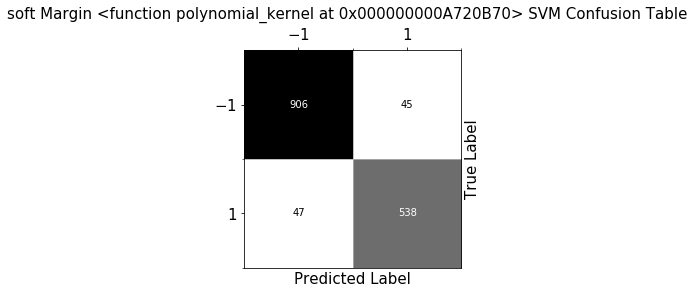

OVERALL TIME FOR FIT: 0.0h:0.0m:32.08184s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 97.45% | TRAIN ERROR RATE: 2.55%
  TRAIN FALSE NEGATIVES: 1.80% | TRAIN FALSE POSTIVES: 0.75%
TEST ACCURACY: 94.01% | TEST ERROR RATE: 5.99%
  TEST FALSE NEGATIVES: 3.06% | TEST FALSE POSTIVES: 2.93%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
476 Support Vectors Found Out of 2000 Data-Points


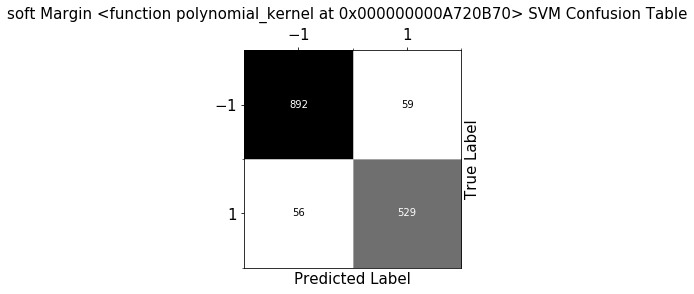

OVERALL TIME FOR FIT: 0.0h:0.0m:36.30508s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 98.70% | TRAIN ERROR RATE: 1.30%
  TRAIN FALSE NEGATIVES: 1.20% | TRAIN FALSE POSTIVES: 0.10%
TEST ACCURACY: 92.51% | TEST ERROR RATE: 7.49%
  TEST FALSE NEGATIVES: 3.65% | TEST FALSE POSTIVES: 3.84%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
474 Support Vectors Found Out of 2000 Data-Points


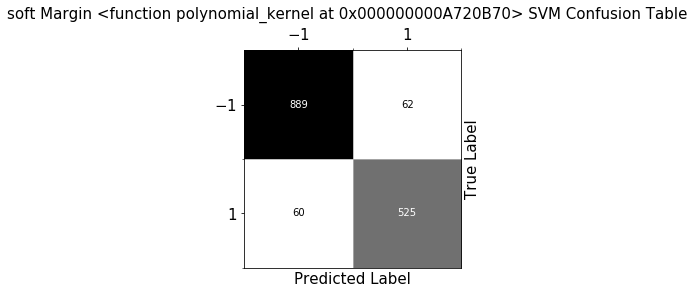

OVERALL TIME FOR FIT: 0.0h:0.0m:49.56984s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 98.95% | TRAIN ERROR RATE: 1.05%
  TRAIN FALSE NEGATIVES: 1.00% | TRAIN FALSE POSTIVES: 0.05%
TEST ACCURACY: 92.06% | TEST ERROR RATE: 7.94%
  TEST FALSE NEGATIVES: 3.91% | TEST FALSE POSTIVES: 4.04%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
461 Support Vectors Found Out of 2000 Data-Points


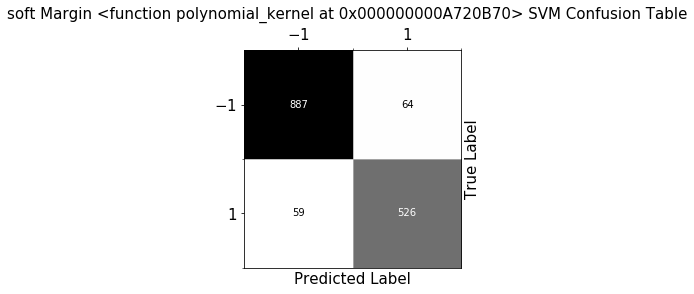

OVERALL TIME FOR FIT: 0.0h:0.0m:41.45037s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 99.05% | TRAIN ERROR RATE: 0.95%
  TRAIN FALSE NEGATIVES: 0.95% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 91.99% | TEST ERROR RATE: 8.01%
  TEST FALSE NEGATIVES: 3.84% | TEST FALSE POSTIVES: 4.17%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
489 Support Vectors Found Out of 2000 Data-Points


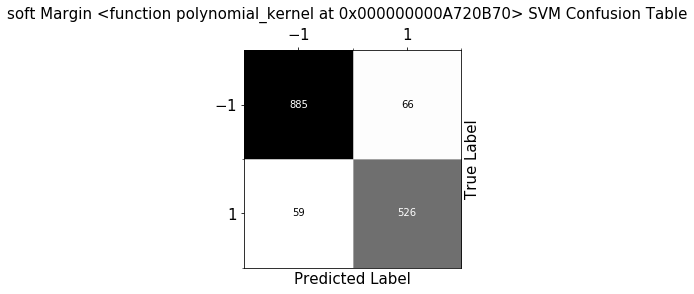

OVERALL TIME FOR FIT: 0.0h:0.0m:40.11729s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 99.10% | TRAIN ERROR RATE: 0.90%
  TRAIN FALSE NEGATIVES: 0.90% | TRAIN FALSE POSTIVES: 0.00%
TEST ACCURACY: 91.86% | TEST ERROR RATE: 8.14%
  TEST FALSE NEGATIVES: 3.84% | TEST FALSE POSTIVES: 4.30%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
493 Support Vectors Found Out of 2000 Data-Points


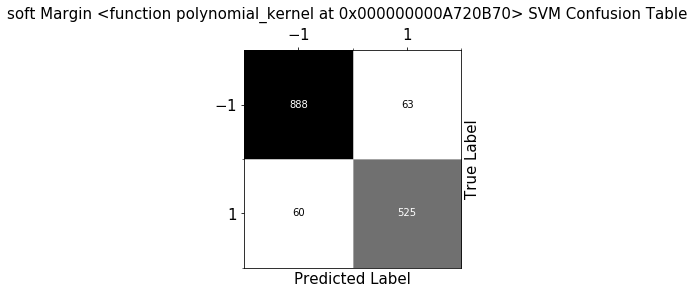

OVERALL TIME FOR FIT: 0.0h:0.0m:39.94528s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 99.15% | TRAIN ERROR RATE: 0.85%
  TRAIN FALSE NEGATIVES: 0.70% | TRAIN FALSE POSTIVES: 0.15%
TEST ACCURACY: 91.99% | TEST ERROR RATE: 8.01%
  TEST FALSE NEGATIVES: 3.91% | TEST FALSE POSTIVES: 4.10%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
493 Support Vectors Found Out of 2000 Data-Points


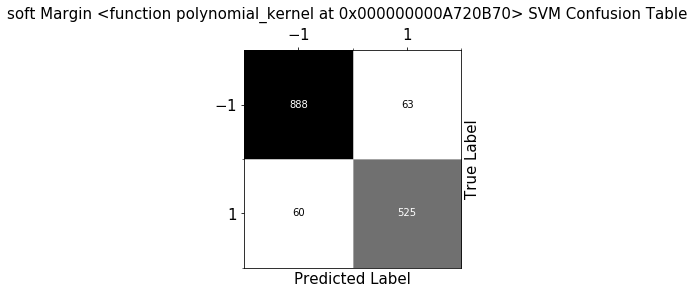

OVERALL TIME FOR FIT: 0.0h:0.0m:34.01995s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 99.15% | TRAIN ERROR RATE: 0.85%
  TRAIN FALSE NEGATIVES: 0.70% | TRAIN FALSE POSTIVES: 0.15%
TEST ACCURACY: 91.99% | TEST ERROR RATE: 8.01%
  TEST FALSE NEGATIVES: 3.91% | TEST FALSE POSTIVES: 4.10%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
493 Support Vectors Found Out of 2000 Data-Points


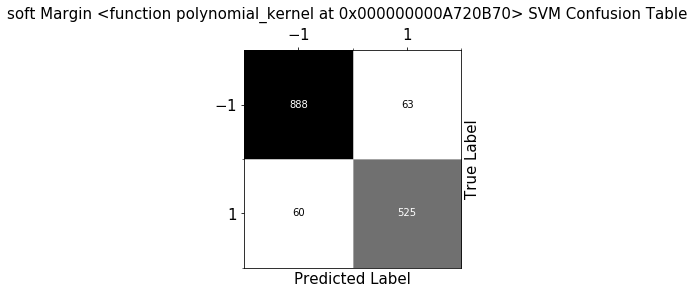

OVERALL TIME FOR FIT: 0.0h:0.0m:36.62309s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 99.15% | TRAIN ERROR RATE: 0.85%
  TRAIN FALSE NEGATIVES: 0.70% | TRAIN FALSE POSTIVES: 0.15%
TEST ACCURACY: 91.99% | TEST ERROR RATE: 8.01%
  TEST FALSE NEGATIVES: 3.91% | TEST FALSE POSTIVES: 4.10%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
448 Support Vectors Found Out of 2000 Data-Points


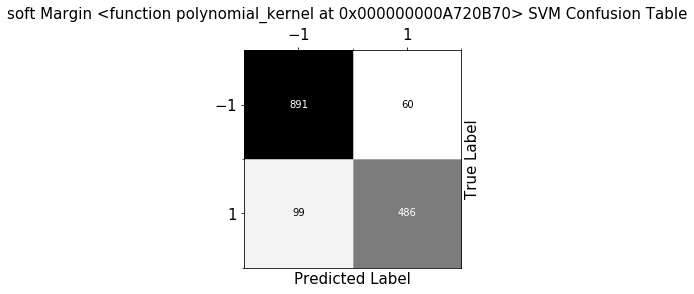

OVERALL TIME FOR FIT: 0.0h:0.0m:46.29065s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 95.45% | TRAIN ERROR RATE: 4.55%
  TRAIN FALSE NEGATIVES: 4.30% | TRAIN FALSE POSTIVES: 0.25%
TEST ACCURACY: 89.65% | TEST ERROR RATE: 10.35%
  TEST FALSE NEGATIVES: 6.45% | TEST FALSE POSTIVES: 3.91%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
448 Support Vectors Found Out of 2000 Data-Points


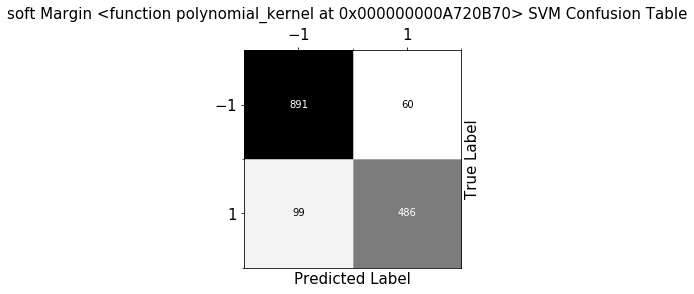

OVERALL TIME FOR FIT: 0.0h:0.0m:32.29285s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 95.50% | TRAIN ERROR RATE: 4.50%
  TRAIN FALSE NEGATIVES: 4.25% | TRAIN FALSE POSTIVES: 0.25%
TEST ACCURACY: 89.65% | TEST ERROR RATE: 10.35%
  TEST FALSE NEGATIVES: 6.45% | TEST FALSE POSTIVES: 3.91%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
448 Support Vectors Found Out of 2000 Data-Points


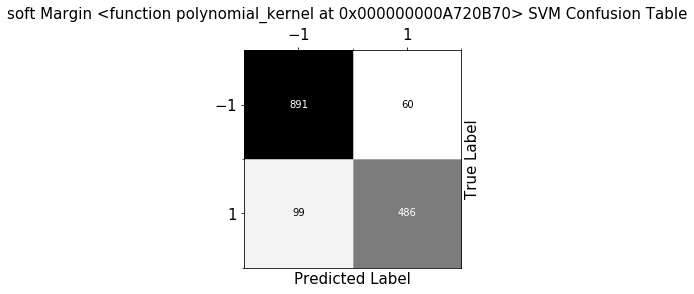

OVERALL TIME FOR FIT: 0.0h:0.0m:49.25382s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 95.50% | TRAIN ERROR RATE: 4.50%
  TRAIN FALSE NEGATIVES: 4.25% | TRAIN FALSE POSTIVES: 0.25%
TEST ACCURACY: 89.65% | TEST ERROR RATE: 10.35%
  TEST FALSE NEGATIVES: 6.45% | TEST FALSE POSTIVES: 3.91%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
448 Support Vectors Found Out of 2000 Data-Points


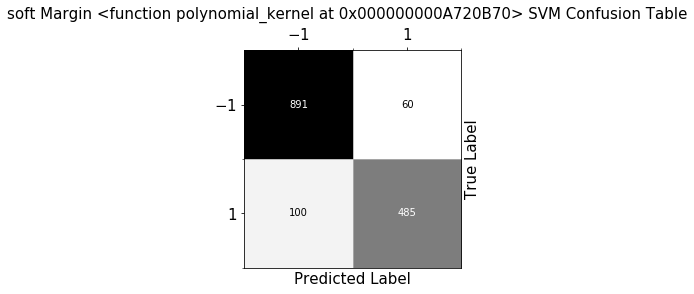

OVERALL TIME FOR FIT: 0.0h:0.0m:31.94183s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 95.50% | TRAIN ERROR RATE: 4.50%
  TRAIN FALSE NEGATIVES: 4.25% | TRAIN FALSE POSTIVES: 0.25%
TEST ACCURACY: 89.58% | TEST ERROR RATE: 10.42%
  TEST FALSE NEGATIVES: 6.51% | TEST FALSE POSTIVES: 3.91%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
310 Support Vectors Found Out of 2000 Data-Points


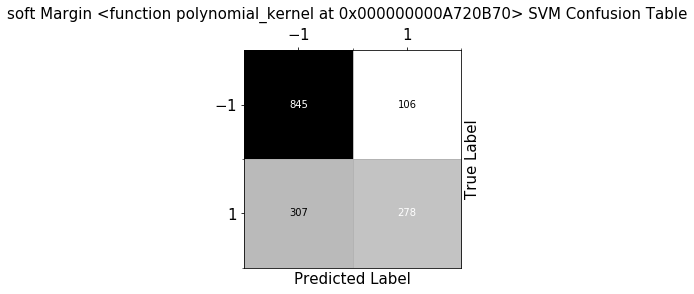

OVERALL TIME FOR FIT: 0.0h:0.0m:31.23879s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 75.75% | TRAIN ERROR RATE: 24.25%
  TRAIN FALSE NEGATIVES: 18.70% | TRAIN FALSE POSTIVES: 5.55%
TEST ACCURACY: 73.11% | TEST ERROR RATE: 26.89%
  TEST FALSE NEGATIVES: 19.99% | TEST FALSE POSTIVES: 6.90%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
311 Support Vectors Found Out of 2000 Data-Points


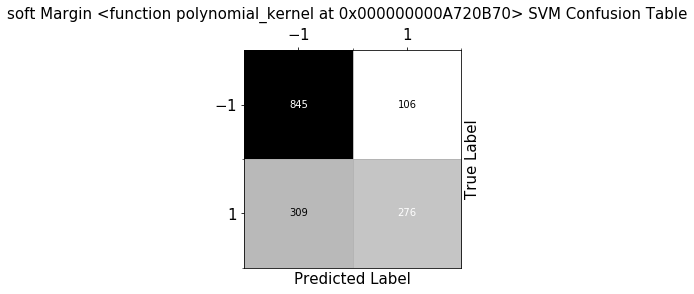

OVERALL TIME FOR FIT: 0.0h:0.0m:30.39474s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 75.45% | TRAIN ERROR RATE: 24.55%
  TRAIN FALSE NEGATIVES: 18.90% | TRAIN FALSE POSTIVES: 5.65%
TEST ACCURACY: 72.98% | TEST ERROR RATE: 27.02%
  TEST FALSE NEGATIVES: 20.12% | TEST FALSE POSTIVES: 6.90%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
311 Support Vectors Found Out of 2000 Data-Points


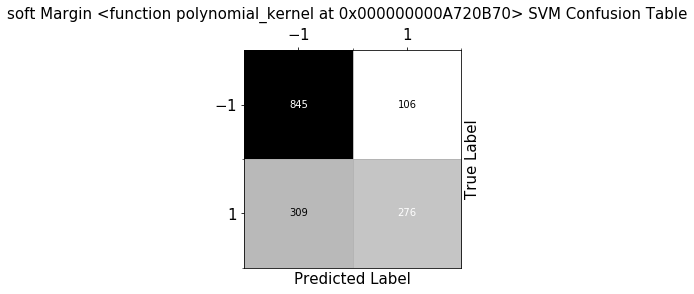

OVERALL TIME FOR FIT: 0.0h:0.0m:31.51780s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 75.45% | TRAIN ERROR RATE: 24.55%
  TRAIN FALSE NEGATIVES: 18.90% | TRAIN FALSE POSTIVES: 5.65%
TEST ACCURACY: 72.98% | TEST ERROR RATE: 27.02%
  TEST FALSE NEGATIVES: 20.12% | TEST FALSE POSTIVES: 6.90%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
311 Support Vectors Found Out of 2000 Data-Points


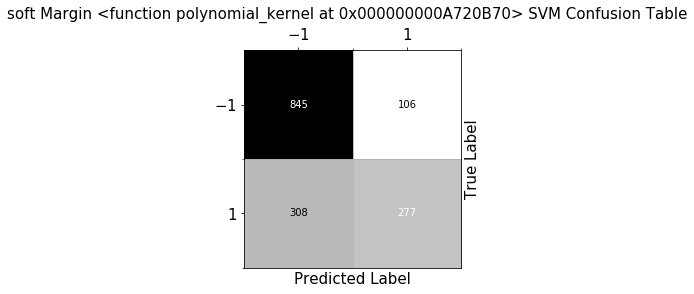

OVERALL TIME FOR FIT: 0.0h:0.0m:30.36174s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 75.45% | TRAIN ERROR RATE: 24.55%
  TRAIN FALSE NEGATIVES: 18.90% | TRAIN FALSE POSTIVES: 5.65%
TEST ACCURACY: 73.05% | TEST ERROR RATE: 26.95%
  TEST FALSE NEGATIVES: 20.05% | TEST FALSE POSTIVES: 6.90%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_STD
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=15-D PCA
######################################################################################
566 Support Vectors Found Out of 2000 Data-Points


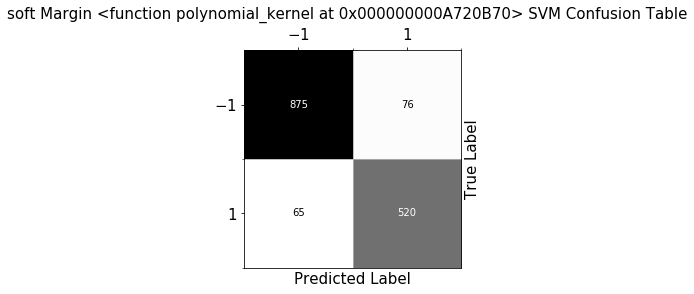

OVERALL TIME FOR FIT: 0.0h:0.0m:37.67615s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 90.45% | TRAIN ERROR RATE: 9.55%
  TRAIN FALSE NEGATIVES: 5.40% | TRAIN FALSE POSTIVES: 4.15%
TEST ACCURACY: 90.82% | TEST ERROR RATE: 9.18%
  TEST FALSE NEGATIVES: 4.23% | TEST FALSE POSTIVES: 4.95%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=15-D PCA
######################################################################################
540 Support Vectors Found Out of 2000 Data-Points


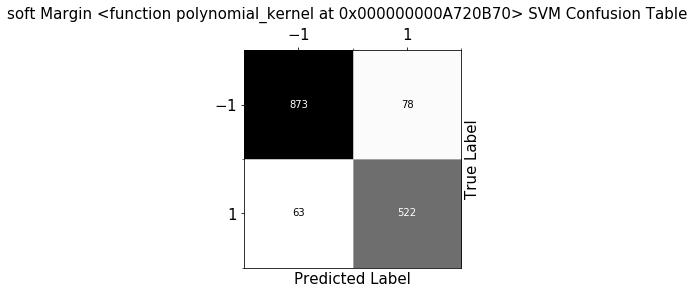

OVERALL TIME FOR FIT: 0.0h:0.0m:37.44214s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 90.75% | TRAIN ERROR RATE: 9.25%
  TRAIN FALSE NEGATIVES: 5.15% | TRAIN FALSE POSTIVES: 4.10%
TEST ACCURACY: 90.82% | TEST ERROR RATE: 9.18%
  TEST FALSE NEGATIVES: 4.10% | TEST FALSE POSTIVES: 5.08%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=15-D PCA
######################################################################################
536 Support Vectors Found Out of 2000 Data-Points


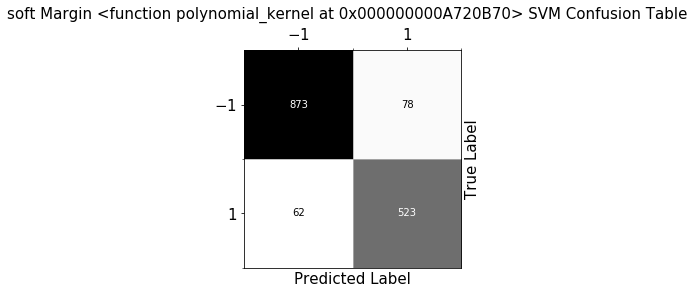

OVERALL TIME FOR FIT: 0.0h:0.0m:43.34248s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 90.70% | TRAIN ERROR RATE: 9.30%
  TRAIN FALSE NEGATIVES: 5.20% | TRAIN FALSE POSTIVES: 4.10%
TEST ACCURACY: 90.89% | TEST ERROR RATE: 9.11%
  TEST FALSE NEGATIVES: 4.04% | TEST FALSE POSTIVES: 5.08%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=15-D PCA
######################################################################################
539 Support Vectors Found Out of 2000 Data-Points


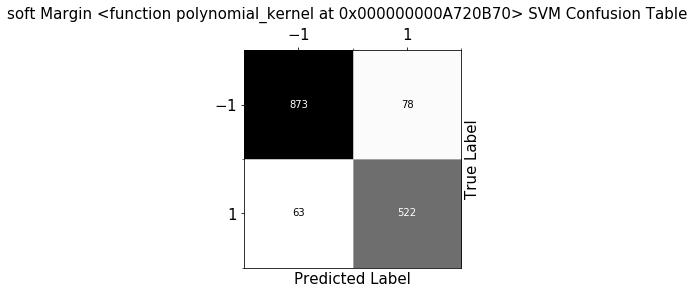

OVERALL TIME FOR FIT: 0.0h:0.0m:56.37022s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 90.65% | TRAIN ERROR RATE: 9.35%
  TRAIN FALSE NEGATIVES: 5.20% | TRAIN FALSE POSTIVES: 4.15%
TEST ACCURACY: 90.82% | TEST ERROR RATE: 9.18%
  TEST FALSE NEGATIVES: 4.10% | TEST FALSE POSTIVES: 5.08%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=15-D PCA
######################################################################################
426 Support Vectors Found Out of 2000 Data-Points


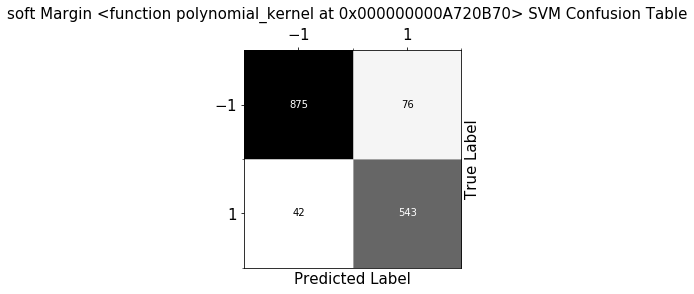

OVERALL TIME FOR FIT: 0.0h:0.0m:49.75085s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 94.95% | TRAIN ERROR RATE: 5.05%
  TRAIN FALSE NEGATIVES: 3.00% | TRAIN FALSE POSTIVES: 2.05%
TEST ACCURACY: 92.32% | TEST ERROR RATE: 7.68%
  TEST FALSE NEGATIVES: 2.73% | TEST FALSE POSTIVES: 4.95%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=15-D PCA
######################################################################################
369 Support Vectors Found Out of 2000 Data-Points


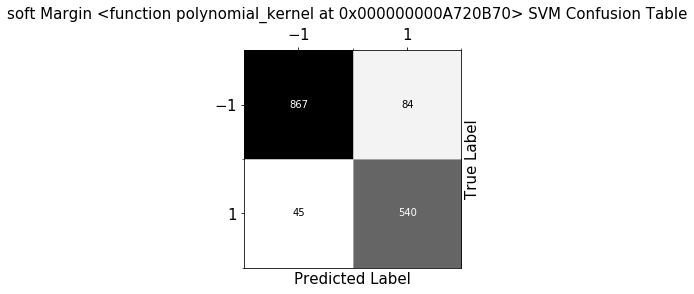

OVERALL TIME FOR FIT: 0.0h:0.0m:43.36648s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 95.45% | TRAIN ERROR RATE: 4.55%
  TRAIN FALSE NEGATIVES: 2.65% | TRAIN FALSE POSTIVES: 1.90%
TEST ACCURACY: 91.60% | TEST ERROR RATE: 8.40%
  TEST FALSE NEGATIVES: 2.93% | TEST FALSE POSTIVES: 5.47%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=15-D PCA
######################################################################################
356 Support Vectors Found Out of 2000 Data-Points


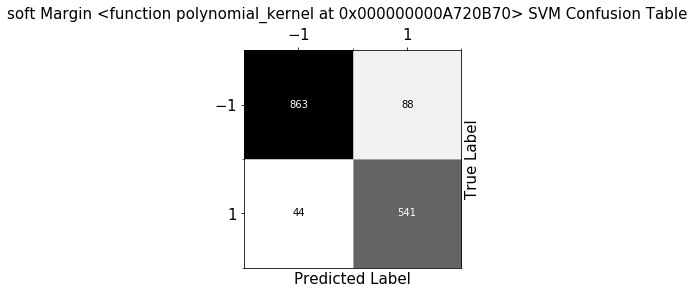

OVERALL TIME FOR FIT: 0.0h:0.0m:50.70590s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 95.40% | TRAIN ERROR RATE: 4.60%
  TRAIN FALSE NEGATIVES: 2.75% | TRAIN FALSE POSTIVES: 1.85%
TEST ACCURACY: 91.41% | TEST ERROR RATE: 8.59%
  TEST FALSE NEGATIVES: 2.86% | TEST FALSE POSTIVES: 5.73%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=15-D PCA
######################################################################################
353 Support Vectors Found Out of 2000 Data-Points


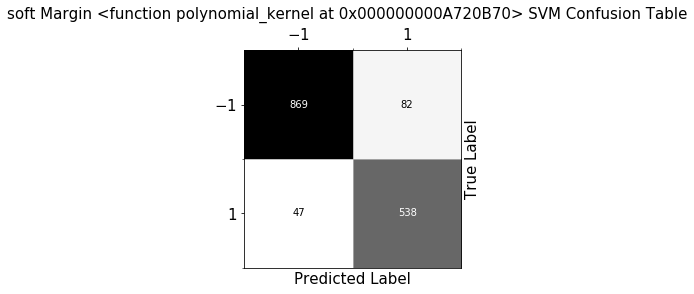

OVERALL TIME FOR FIT: 0.0h:0.0m:51.84597s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 95.30% | TRAIN ERROR RATE: 4.70%
  TRAIN FALSE NEGATIVES: 2.80% | TRAIN FALSE POSTIVES: 1.90%
TEST ACCURACY: 91.60% | TEST ERROR RATE: 8.40%
  TEST FALSE NEGATIVES: 3.06% | TEST FALSE POSTIVES: 5.34%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=15-D PCA
######################################################################################
400 Support Vectors Found Out of 2000 Data-Points


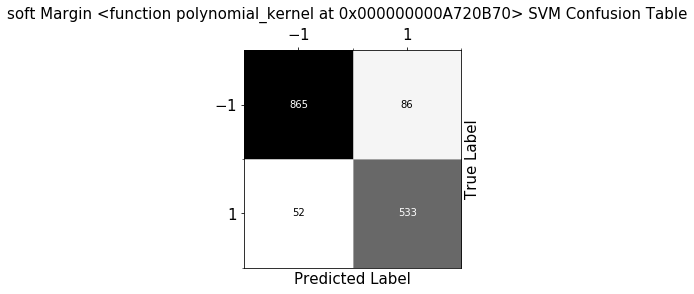

OVERALL TIME FOR FIT: 0.0h:0.0m:51.41694s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 97.35% | TRAIN ERROR RATE: 2.65%
  TRAIN FALSE NEGATIVES: 1.65% | TRAIN FALSE POSTIVES: 1.00%
TEST ACCURACY: 91.02% | TEST ERROR RATE: 8.98%
  TEST FALSE NEGATIVES: 3.39% | TEST FALSE POSTIVES: 5.60%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=15-D PCA
######################################################################################
369 Support Vectors Found Out of 2000 Data-Points


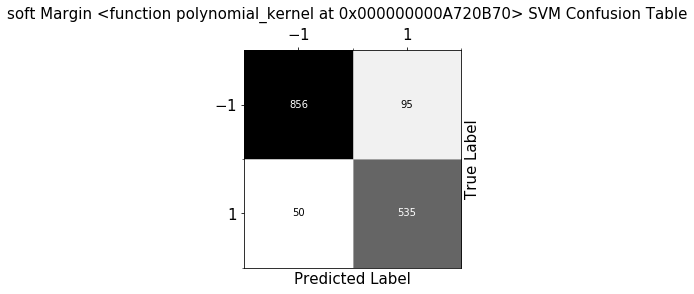

OVERALL TIME FOR FIT: 0.0h:0.0m:54.95114s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 98.90% | TRAIN ERROR RATE: 1.10%
  TRAIN FALSE NEGATIVES: 1.00% | TRAIN FALSE POSTIVES: 0.10%
TEST ACCURACY: 90.56% | TEST ERROR RATE: 9.44%
  TEST FALSE NEGATIVES: 3.26% | TEST FALSE POSTIVES: 6.18%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=15-D PCA
######################################################################################
363 Support Vectors Found Out of 2000 Data-Points


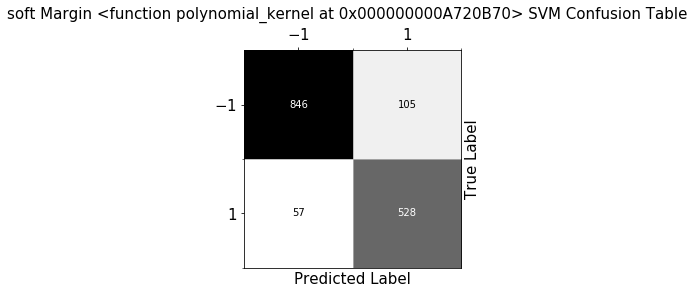

OVERALL TIME FOR FIT: 0.0h:0.0m:59.54741s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 98.85% | TRAIN ERROR RATE: 1.15%
  TRAIN FALSE NEGATIVES: 0.95% | TRAIN FALSE POSTIVES: 0.20%
TEST ACCURACY: 89.45% | TEST ERROR RATE: 10.55%
  TEST FALSE NEGATIVES: 3.71% | TEST FALSE POSTIVES: 6.84%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=15-D PCA
######################################################################################
362 Support Vectors Found Out of 2000 Data-Points


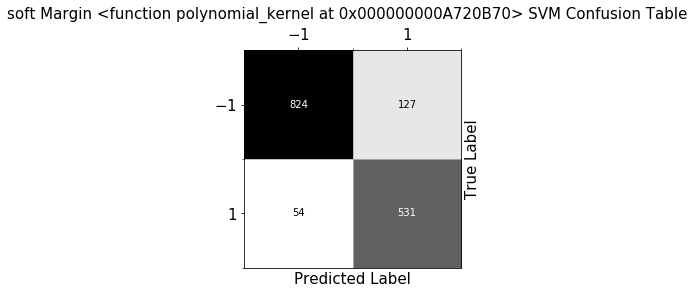

OVERALL TIME FOR FIT: 0.0h:0.0m:57.48429s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 99.20% | TRAIN ERROR RATE: 0.80%
  TRAIN FALSE NEGATIVES: 0.65% | TRAIN FALSE POSTIVES: 0.15%
TEST ACCURACY: 88.22% | TEST ERROR RATE: 11.78%
  TEST FALSE NEGATIVES: 3.52% | TEST FALSE POSTIVES: 8.27%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=15-D PCA
######################################################################################
403 Support Vectors Found Out of 2000 Data-Points


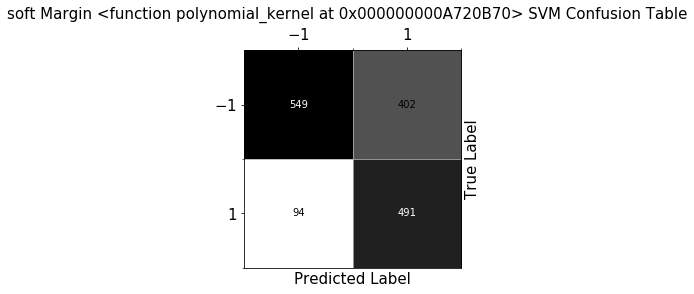

OVERALL TIME FOR FIT: 0.0h:1.0m:9.36597s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 69.65% | TRAIN ERROR RATE: 30.35%
  TRAIN FALSE NEGATIVES: 8.20% | TRAIN FALSE POSTIVES: 22.15%
TEST ACCURACY: 67.71% | TEST ERROR RATE: 32.29%
  TEST FALSE NEGATIVES: 6.12% | TEST FALSE POSTIVES: 26.17%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=15-D PCA
######################################################################################
387 Support Vectors Found Out of 2000 Data-Points


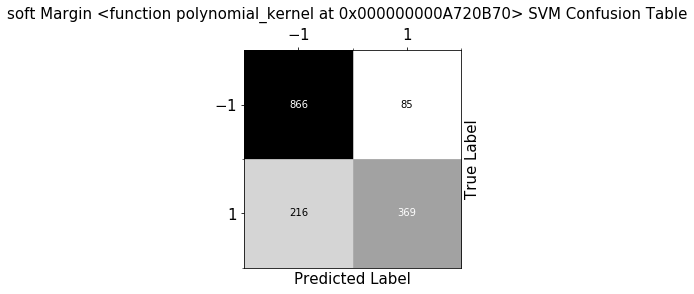

OVERALL TIME FOR FIT: 0.0h:1.0m:0.74647s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 80.05% | TRAIN ERROR RATE: 19.95%
  TRAIN FALSE NEGATIVES: 17.95% | TRAIN FALSE POSTIVES: 2.00%
TEST ACCURACY: 80.40% | TEST ERROR RATE: 19.60%
  TEST FALSE NEGATIVES: 14.06% | TEST FALSE POSTIVES: 5.53%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=15-D PCA
######################################################################################
375 Support Vectors Found Out of 2000 Data-Points


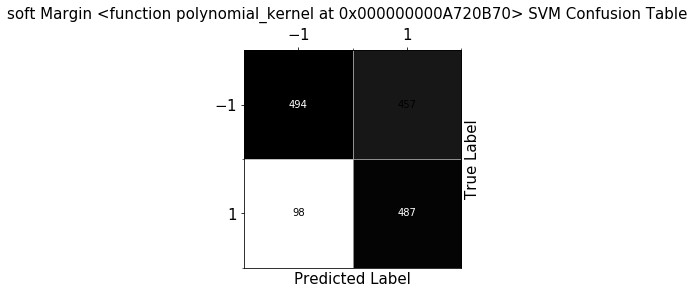

OVERALL TIME FOR FIT: 0.0h:0.0m:58.01132s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 67.50% | TRAIN ERROR RATE: 32.50%
  TRAIN FALSE NEGATIVES: 6.20% | TRAIN FALSE POSTIVES: 26.30%
TEST ACCURACY: 63.87% | TEST ERROR RATE: 36.13%
  TEST FALSE NEGATIVES: 6.38% | TEST FALSE POSTIVES: 29.75%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=15-D PCA
######################################################################################
372 Support Vectors Found Out of 2000 Data-Points


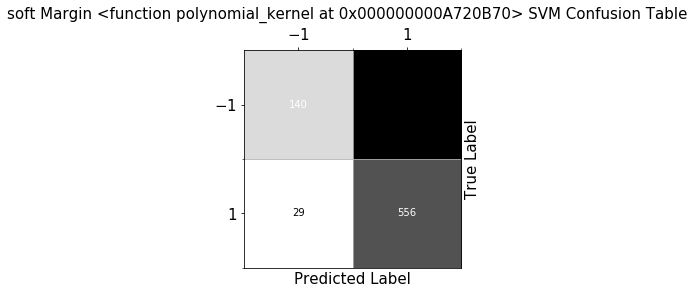

OVERALL TIME FOR FIT: 0.0h:1.0m:1.53252s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 47.00% | TRAIN ERROR RATE: 53.00%
  TRAIN FALSE NEGATIVES: 2.75% | TRAIN FALSE POSTIVES: 50.25%
TEST ACCURACY: 45.31% | TEST ERROR RATE: 54.69%
  TEST FALSE NEGATIVES: 1.89% | TEST FALSE POSTIVES: 52.80%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=15-D PCA
######################################################################################
346 Support Vectors Found Out of 2000 Data-Points


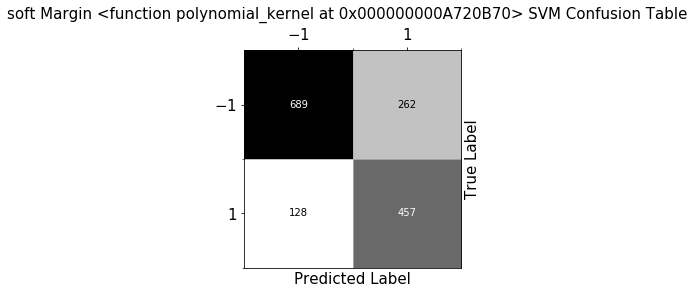

OVERALL TIME FOR FIT: 0.0h:1.0m:6.64381s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 86.70% | TRAIN ERROR RATE: 13.30%
  TRAIN FALSE NEGATIVES: 7.70% | TRAIN FALSE POSTIVES: 5.60%
TEST ACCURACY: 74.61% | TEST ERROR RATE: 25.39%
  TEST FALSE NEGATIVES: 8.33% | TEST FALSE POSTIVES: 17.06%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=15-D PCA
######################################################################################
334 Support Vectors Found Out of 2000 Data-Points


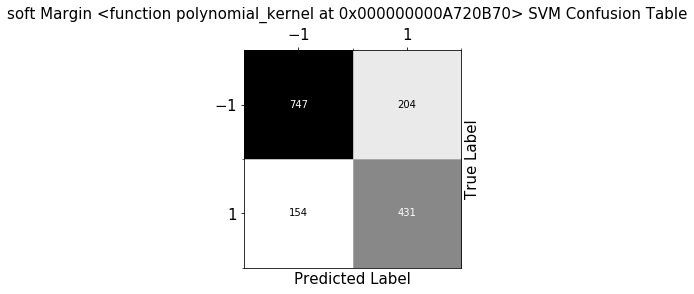

OVERALL TIME FOR FIT: 0.0h:1.0m:4.07266s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 86.25% | TRAIN ERROR RATE: 13.75%
  TRAIN FALSE NEGATIVES: 8.60% | TRAIN FALSE POSTIVES: 5.15%
TEST ACCURACY: 76.69% | TEST ERROR RATE: 23.31%
  TEST FALSE NEGATIVES: 10.03% | TEST FALSE POSTIVES: 13.28%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=15-D PCA
######################################################################################
329 Support Vectors Found Out of 2000 Data-Points


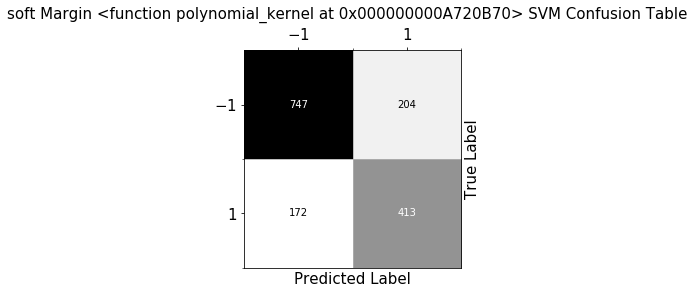

OVERALL TIME FOR FIT: 0.0h:1.0m:7.93789s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 84.10% | TRAIN ERROR RATE: 15.90%
  TRAIN FALSE NEGATIVES: 10.15% | TRAIN FALSE POSTIVES: 5.75%
TEST ACCURACY: 75.52% | TEST ERROR RATE: 24.48%
  TEST FALSE NEGATIVES: 11.20% | TEST FALSE POSTIVES: 13.28%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=15-D PCA
######################################################################################
317 Support Vectors Found Out of 2000 Data-Points


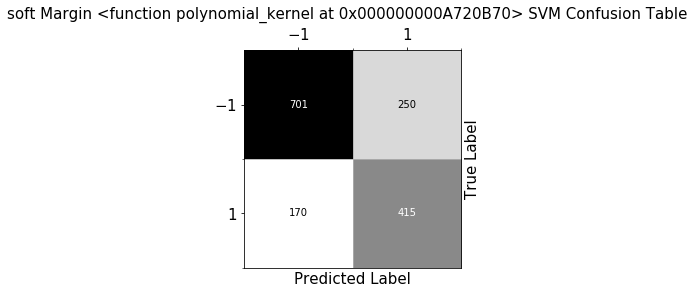

OVERALL TIME FOR FIT: 0.0h:1.0m:6.79882s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 82.35% | TRAIN ERROR RATE: 17.65%
  TRAIN FALSE NEGATIVES: 11.00% | TRAIN FALSE POSTIVES: 6.65%
TEST ACCURACY: 72.66% | TEST ERROR RATE: 27.34%
  TEST FALSE NEGATIVES: 11.07% | TEST FALSE POSTIVES: 16.28%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_LOG
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=2-D LDA
######################################################################################


D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:93: ComplexWarning: Casting complex values to real discards the imaginary part
D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:98: ComplexWarning: Casting complex values to real discards the imaginary part


354 Support Vectors Found Out of 2000 Data-Points


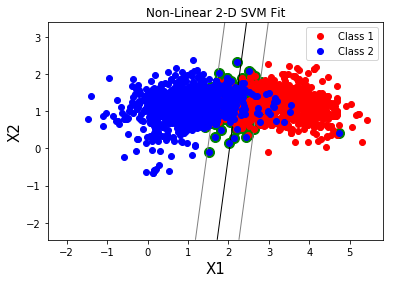

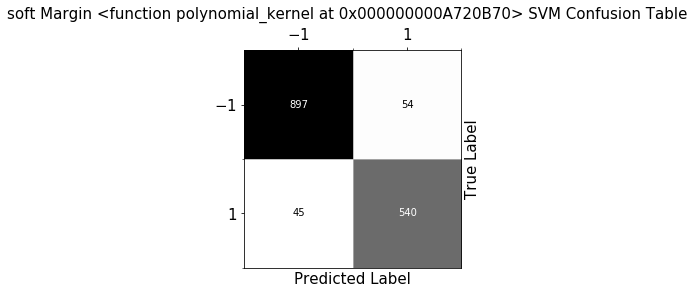

OVERALL TIME FOR FIT: 0.0h:0.0m:42.92146s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.40% | TRAIN ERROR RATE: 5.60%
  TRAIN FALSE NEGATIVES: 2.90% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.55% | TEST ERROR RATE: 6.45%
  TEST FALSE NEGATIVES: 2.93% | TEST FALSE POSTIVES: 3.52%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=2-D LDA
######################################################################################
324 Support Vectors Found Out of 2000 Data-Points


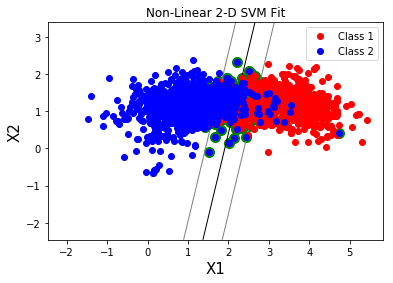

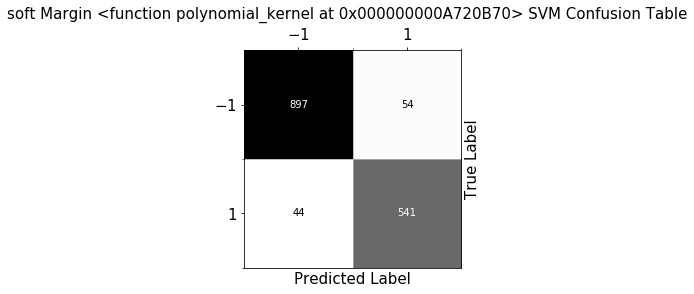

OVERALL TIME FOR FIT: 0.0h:0.0m:45.22159s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.50% | TRAIN ERROR RATE: 5.50%
  TRAIN FALSE NEGATIVES: 2.80% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.62% | TEST ERROR RATE: 6.38%
  TEST FALSE NEGATIVES: 2.86% | TEST FALSE POSTIVES: 3.52%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=2-D LDA
######################################################################################
321 Support Vectors Found Out of 2000 Data-Points


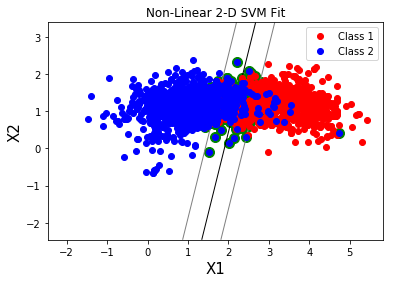

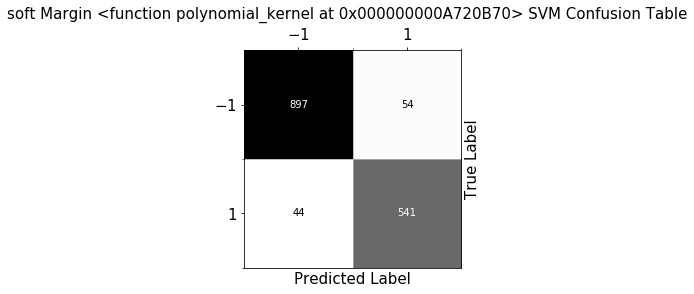

OVERALL TIME FOR FIT: 0.0h:1.0m:5.66276s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.50% | TRAIN ERROR RATE: 5.50%
  TRAIN FALSE NEGATIVES: 2.80% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.62% | TEST ERROR RATE: 6.38%
  TEST FALSE NEGATIVES: 2.86% | TEST FALSE POSTIVES: 3.52%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=1
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=2-D LDA
######################################################################################
320 Support Vectors Found Out of 2000 Data-Points


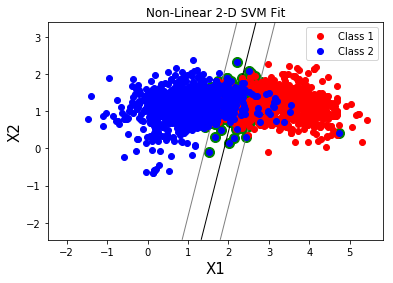

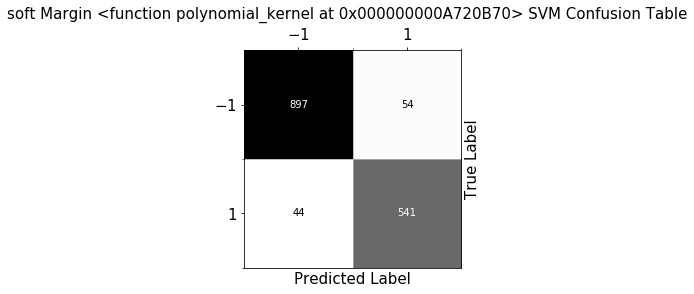

OVERALL TIME FOR FIT: 0.0h:0.0m:37.75816s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.40% | TRAIN ERROR RATE: 5.60%
  TRAIN FALSE NEGATIVES: 2.90% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.62% | TEST ERROR RATE: 6.38%
  TEST FALSE NEGATIVES: 2.86% | TEST FALSE POSTIVES: 3.52%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=2-D LDA
######################################################################################
318 Support Vectors Found Out of 2000 Data-Points


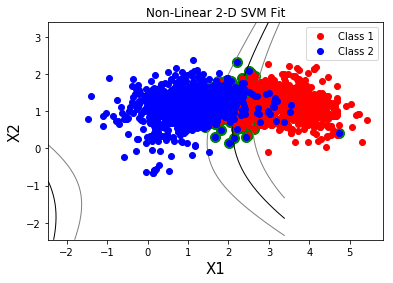

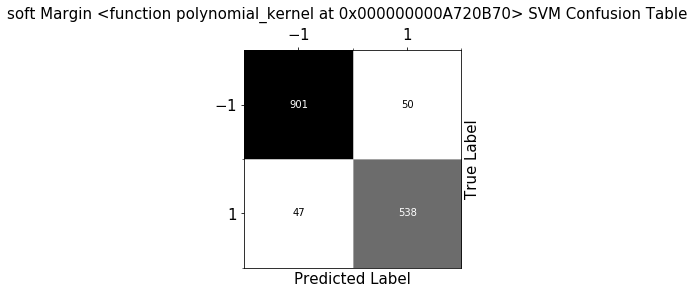

OVERALL TIME FOR FIT: 0.0h:0.0m:48.21376s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.50% | TRAIN ERROR RATE: 5.50%
  TRAIN FALSE NEGATIVES: 3.05% | TRAIN FALSE POSTIVES: 2.45%
TEST ACCURACY: 93.68% | TEST ERROR RATE: 6.32%
  TEST FALSE NEGATIVES: 3.06% | TEST FALSE POSTIVES: 3.26%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=2-D LDA
######################################################################################
316 Support Vectors Found Out of 2000 Data-Points


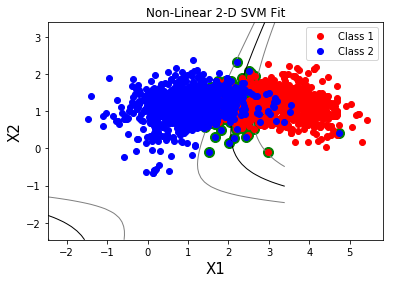

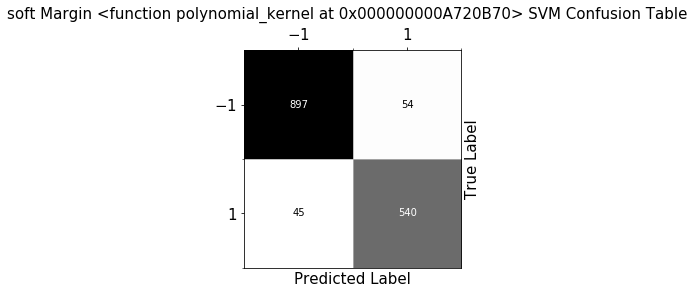

OVERALL TIME FOR FIT: 0.0h:0.0m:40.50932s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.40% | TRAIN ERROR RATE: 5.60%
  TRAIN FALSE NEGATIVES: 2.85% | TRAIN FALSE POSTIVES: 2.75%
TEST ACCURACY: 93.55% | TEST ERROR RATE: 6.45%
  TEST FALSE NEGATIVES: 2.93% | TEST FALSE POSTIVES: 3.52%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=2-D LDA
######################################################################################
315 Support Vectors Found Out of 2000 Data-Points


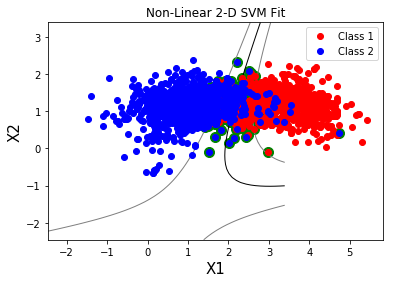

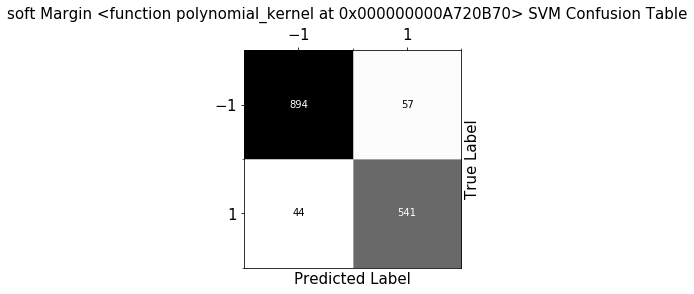

OVERALL TIME FOR FIT: 0.0h:0.0m:54.55112s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.30% | TRAIN ERROR RATE: 5.70%
  TRAIN FALSE NEGATIVES: 2.80% | TRAIN FALSE POSTIVES: 2.90%
TEST ACCURACY: 93.42% | TEST ERROR RATE: 6.58%
  TEST FALSE NEGATIVES: 2.86% | TEST FALSE POSTIVES: 3.71%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=2
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=2-D LDA
######################################################################################
316 Support Vectors Found Out of 2000 Data-Points


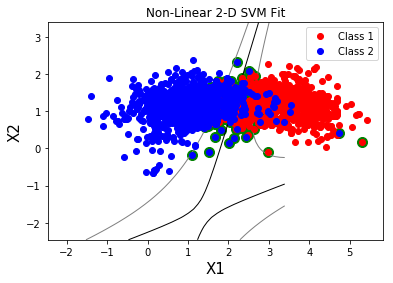

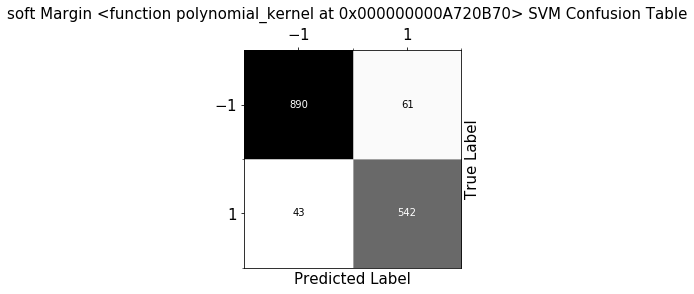

OVERALL TIME FOR FIT: 0.0h:0.0m:45.72562s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.25% | TRAIN ERROR RATE: 5.75%
  TRAIN FALSE NEGATIVES: 2.75% | TRAIN FALSE POSTIVES: 3.00%
TEST ACCURACY: 93.23% | TEST ERROR RATE: 6.77%
  TEST FALSE NEGATIVES: 2.80% | TEST FALSE POSTIVES: 3.97%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=2-D LDA
######################################################################################
312 Support Vectors Found Out of 2000 Data-Points


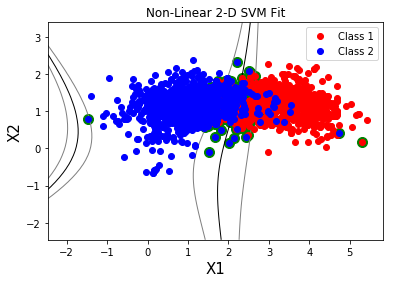

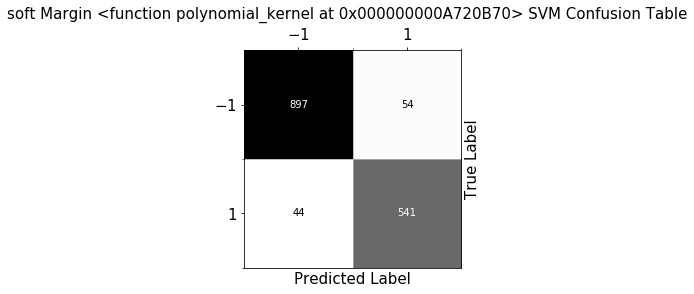

OVERALL TIME FOR FIT: 0.0h:0.0m:46.19364s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.40% | TRAIN ERROR RATE: 5.60%
  TRAIN FALSE NEGATIVES: 2.90% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.62% | TEST ERROR RATE: 6.38%
  TEST FALSE NEGATIVES: 2.86% | TEST FALSE POSTIVES: 3.52%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=2-D LDA
######################################################################################
310 Support Vectors Found Out of 2000 Data-Points


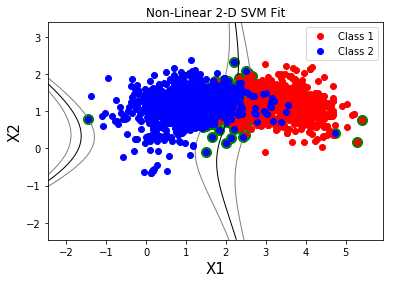

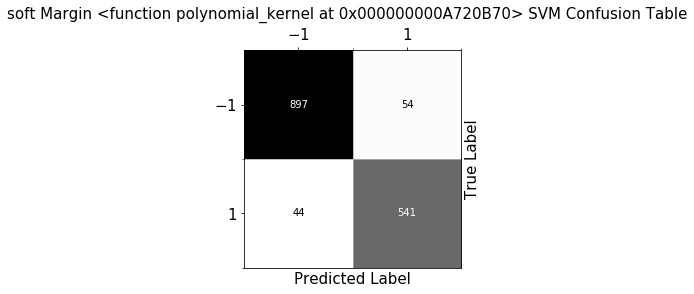

OVERALL TIME FOR FIT: 0.0h:0.0m:49.63584s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.40% | TRAIN ERROR RATE: 5.60%
  TRAIN FALSE NEGATIVES: 2.90% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.62% | TEST ERROR RATE: 6.38%
  TEST FALSE NEGATIVES: 2.86% | TEST FALSE POSTIVES: 3.52%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=2-D LDA
######################################################################################
310 Support Vectors Found Out of 2000 Data-Points


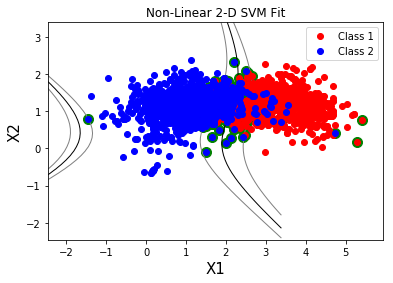

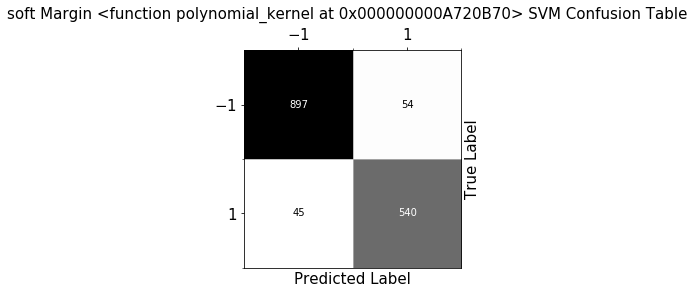

OVERALL TIME FOR FIT: 0.0h:0.0m:42.60644s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.40% | TRAIN ERROR RATE: 5.60%
  TRAIN FALSE NEGATIVES: 2.90% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.55% | TEST ERROR RATE: 6.45%
  TEST FALSE NEGATIVES: 2.93% | TEST FALSE POSTIVES: 3.52%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=3
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=2-D LDA
######################################################################################
309 Support Vectors Found Out of 2000 Data-Points


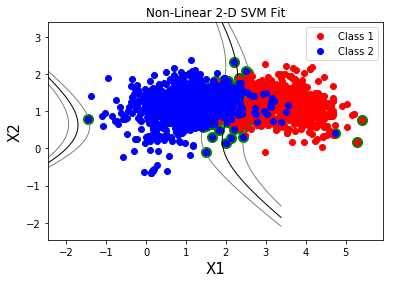

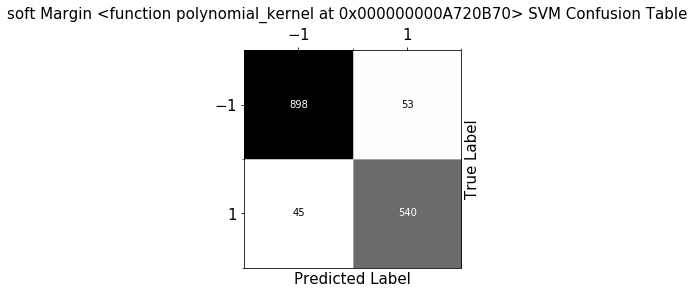

OVERALL TIME FOR FIT: 0.0h:1.0m:5.62075s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.40% | TRAIN ERROR RATE: 5.60%
  TRAIN FALSE NEGATIVES: 2.90% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.62% | TEST ERROR RATE: 6.38%
  TEST FALSE NEGATIVES: 2.93% | TEST FALSE POSTIVES: 3.45%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=2-D LDA
######################################################################################
308 Support Vectors Found Out of 2000 Data-Points


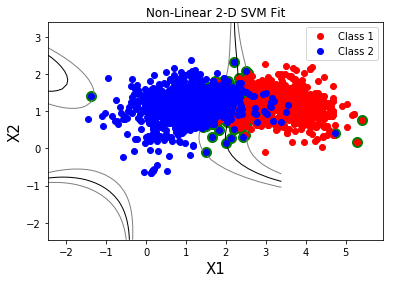

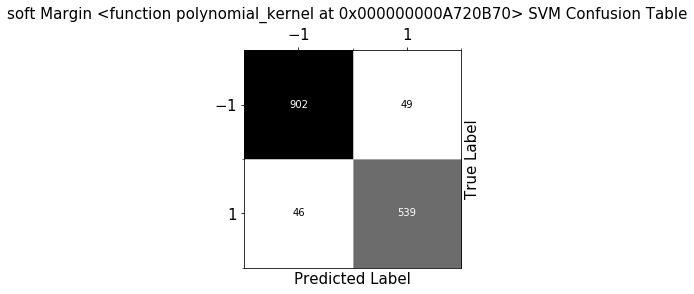

OVERALL TIME FOR FIT: 0.0h:0.0m:46.63567s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.45% | TRAIN ERROR RATE: 5.55%
  TRAIN FALSE NEGATIVES: 3.00% | TRAIN FALSE POSTIVES: 2.55%
TEST ACCURACY: 93.82% | TEST ERROR RATE: 6.18%
  TEST FALSE NEGATIVES: 2.99% | TEST FALSE POSTIVES: 3.19%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=2-D LDA
######################################################################################
306 Support Vectors Found Out of 2000 Data-Points


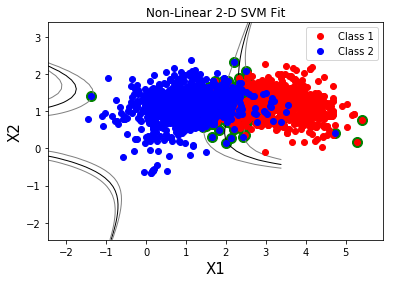

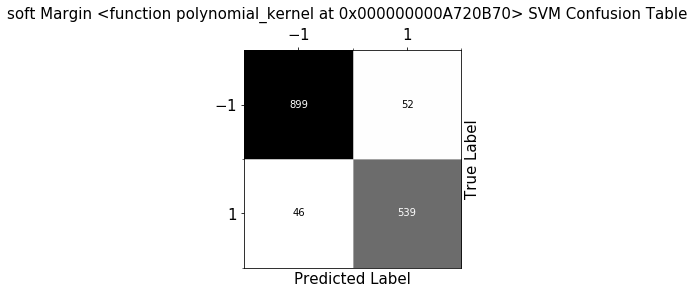

OVERALL TIME FOR FIT: 0.0h:0.0m:47.16170s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.55% | TRAIN ERROR RATE: 5.45%
  TRAIN FALSE NEGATIVES: 2.95% | TRAIN FALSE POSTIVES: 2.50%
TEST ACCURACY: 93.62% | TEST ERROR RATE: 6.38%
  TEST FALSE NEGATIVES: 2.99% | TEST FALSE POSTIVES: 3.39%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=2-D LDA
######################################################################################
307 Support Vectors Found Out of 2000 Data-Points


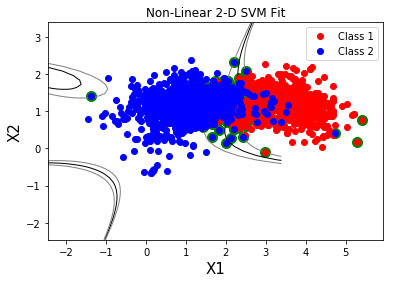

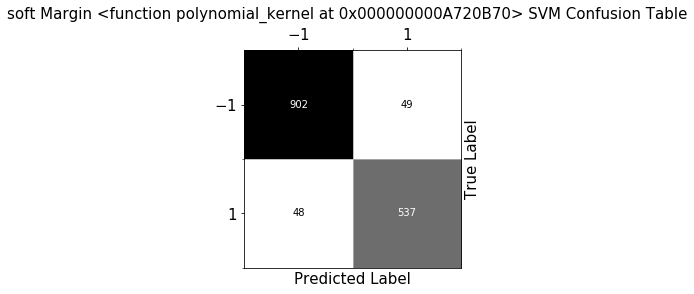

OVERALL TIME FOR FIT: 0.0h:0.0m:55.59818s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.45% | TRAIN ERROR RATE: 5.55%
  TRAIN FALSE NEGATIVES: 3.10% | TRAIN FALSE POSTIVES: 2.45%
TEST ACCURACY: 93.68% | TEST ERROR RATE: 6.32%
  TEST FALSE NEGATIVES: 3.12% | TEST FALSE POSTIVES: 3.19%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=4
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=2-D LDA
######################################################################################
308 Support Vectors Found Out of 2000 Data-Points


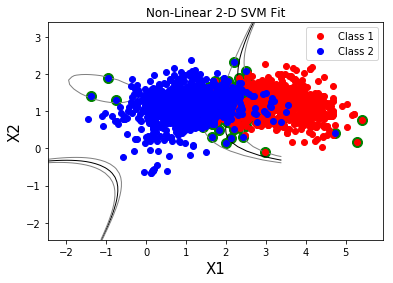

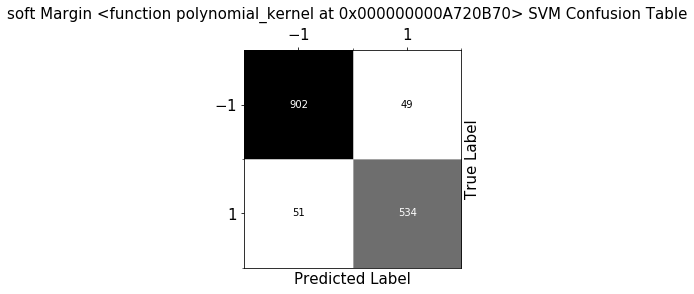

OVERALL TIME FOR FIT: 0.0h:1.0m:10.69404s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.45% | TRAIN ERROR RATE: 5.55%
  TRAIN FALSE NEGATIVES: 3.10% | TRAIN FALSE POSTIVES: 2.45%
TEST ACCURACY: 93.49% | TEST ERROR RATE: 6.51%
  TEST FALSE NEGATIVES: 3.32% | TEST FALSE POSTIVES: 3.19%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=0.1 | TRANSFORM=2-D LDA
######################################################################################
301 Support Vectors Found Out of 2000 Data-Points


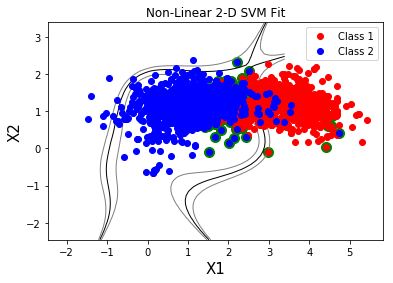

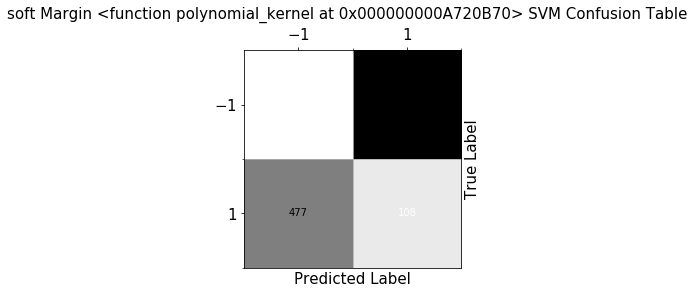

OVERALL TIME FOR FIT: 0.0h:0.0m:48.05975s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 8.90% | TRAIN ERROR RATE: 91.10%
  TRAIN FALSE NEGATIVES: 33.30% | TRAIN FALSE POSTIVES: 57.80%
TEST ACCURACY: 9.18% | TEST ERROR RATE: 90.82%
  TEST FALSE NEGATIVES: 31.05% | TEST FALSE POSTIVES: 59.77%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=0.6 | TRANSFORM=2-D LDA
######################################################################################
295 Support Vectors Found Out of 2000 Data-Points


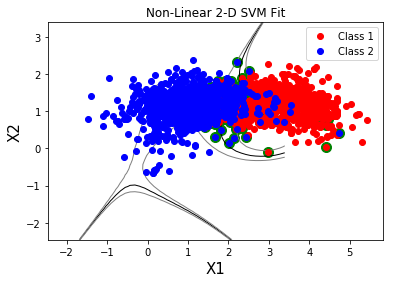

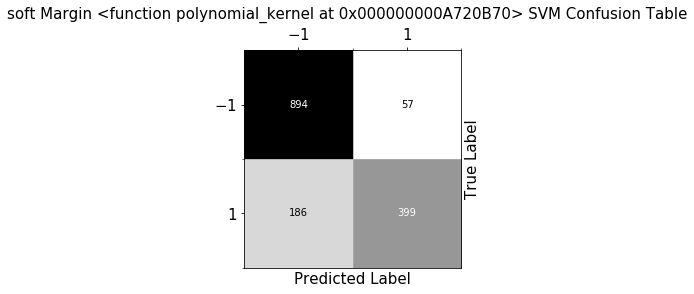

OVERALL TIME FOR FIT: 0.0h:0.0m:54.01009s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 82.60% | TRAIN ERROR RATE: 17.40%
  TRAIN FALSE NEGATIVES: 14.40% | TRAIN FALSE POSTIVES: 3.00%
TEST ACCURACY: 84.18% | TEST ERROR RATE: 15.82%
  TEST FALSE NEGATIVES: 12.11% | TEST FALSE POSTIVES: 3.71%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=2-D LDA
######################################################################################
323 Support Vectors Found Out of 2000 Data-Points


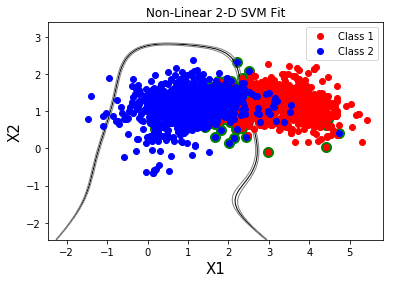

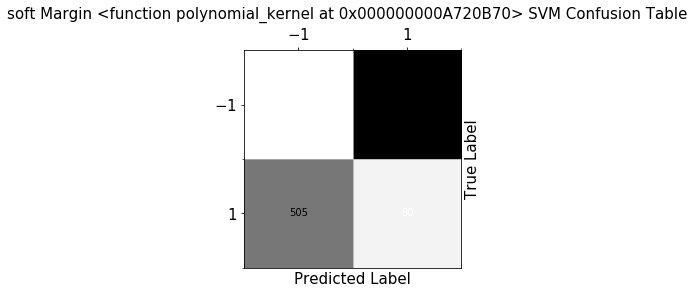

OVERALL TIME FOR FIT: 0.0h:1.0m:5.95777s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 7.25% | TRAIN ERROR RATE: 92.75%
  TRAIN FALSE NEGATIVES: 35.10% | TRAIN FALSE POSTIVES: 57.65%
TEST ACCURACY: 7.68% | TEST ERROR RATE: 92.32%
  TEST FALSE NEGATIVES: 32.88% | TEST FALSE POSTIVES: 59.44%

######################################################################################
SVM FIT | KERNEL=<function polynomial_kernel at 0x000000000A720B70> | p=5
        | MARGIN_TYPE=soft | C=2.1 | TRANSFORM=2-D LDA
######################################################################################
294 Support Vectors Found Out of 2000 Data-Points


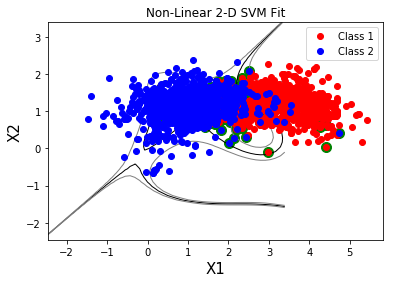

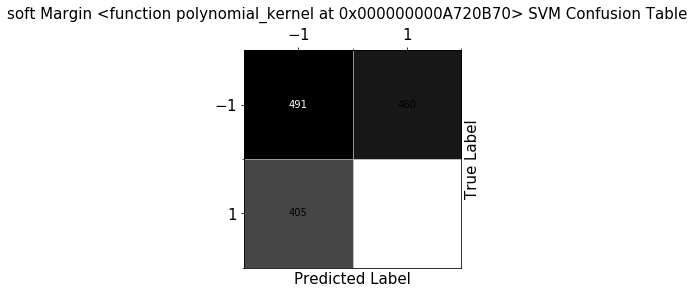

OVERALL TIME FOR FIT: 0.0h:1.0m:5.24473s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 44.45% | TRAIN ERROR RATE: 55.55%
  TRAIN FALSE NEGATIVES: 26.55% | TRAIN FALSE POSTIVES: 29.00%
TEST ACCURACY: 43.68% | TEST ERROR RATE: 56.32%
  TEST FALSE NEGATIVES: 26.37% | TEST FALSE POSTIVES: 29.95%


In [151]:
# RUN SOFT MARGIN POLYNOMIAL KERNEL EXPERIMENT
for idx, (X_train, X_test, transform, dims) in enumerate(zip(X_train_list, X_test_list, Transform_list, Dims_list)):
    print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print("X_train = {}".format(X_train_list_names[idx]))
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    for p in P_list:
        for C in C_list:
            fit_SVM(X_train, T_TRAIN.astype(float), X_test, T_TEST.astype(float),
                    kernel = polynomial_kernel, margin_type = 'soft', C=C, p=p, transform = transform, pp_dims = dims)

## EVALUATION | Soft Margin SVM With Gaussian Kernel

Would You Like to Perform Evaluation? (y/n)
y
Please Indicate if The Evaluation Dataset Args Are Correct? (y/n)
Filename:eval.mat | Data Set:eval_data | Label Set:eval_label
n
Please Enter Filename
test.mat
Please Enter Data Set Variable Name
test_data
Please Enter Label Set Variable Name
test_label
>>>>>> EMAIL EVAL DATASET FEATURE SPACE <<<<<<
(1536, 57)
(1536,)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_BNY
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function gaussian_kernel at 0x000000000BD741E0> | p=None
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=57-D None
######################################################################################
No Transform Will Be Applied.
602 Support Vectors Found Out of 2000 Data-Points


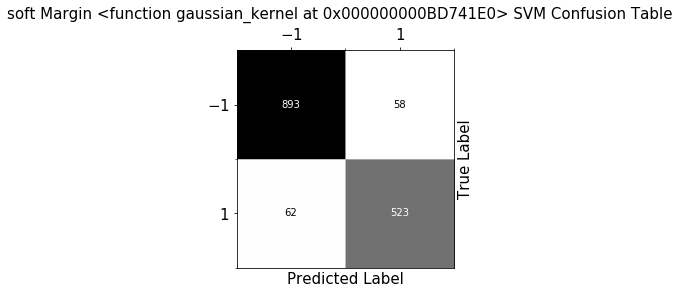

OVERALL TIME FOR FIT: 0.0h:2.0m:2.00198s
DATA DIMENSIONALITY: 57-D
TRAIN ACCURACY: 93.30% | TRAIN ERROR RATE: 6.70%
  TRAIN FALSE NEGATIVES: 4.00% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 92.19% | TEST ERROR RATE: 7.81%
  TEST FALSE NEGATIVES: 4.04% | TEST FALSE POSTIVES: 3.78%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_STD
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function gaussian_kernel at 0x000000000BD741E0> | p=None
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=15-D PCA
######################################################################################
623 Support Vectors Found Out of 2000 Data-Points


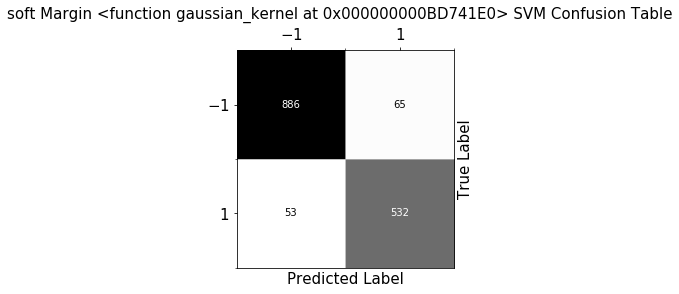

OVERALL TIME FOR FIT: 0.0h:1.0m:54.04652s
DATA DIMENSIONALITY: 15-D
TRAIN ACCURACY: 92.30% | TRAIN ERROR RATE: 7.70%
  TRAIN FALSE NEGATIVES: 3.95% | TRAIN FALSE POSTIVES: 3.75%
TEST ACCURACY: 92.32% | TEST ERROR RATE: 7.68%
  TEST FALSE NEGATIVES: 3.45% | TEST FALSE POSTIVES: 4.23%

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
X_train = X_TRAIN_LOG
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

######################################################################################
SVM FIT | KERNEL=<function gaussian_kernel at 0x000000000BD741E0> | p=None
        | MARGIN_TYPE=soft | C=1.1 | TRANSFORM=2-D LDA
######################################################################################


D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:93: ComplexWarning: Casting complex values to real discards the imaginary part
D:\Work\Anaconda\lib\site-packages\ipykernel_launcher.py:98: ComplexWarning: Casting complex values to real discards the imaginary part


388 Support Vectors Found Out of 2000 Data-Points


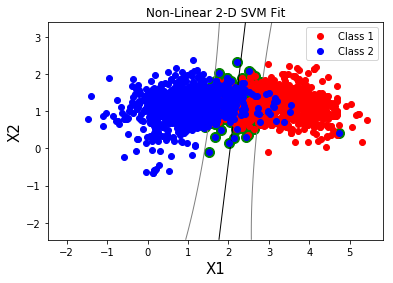

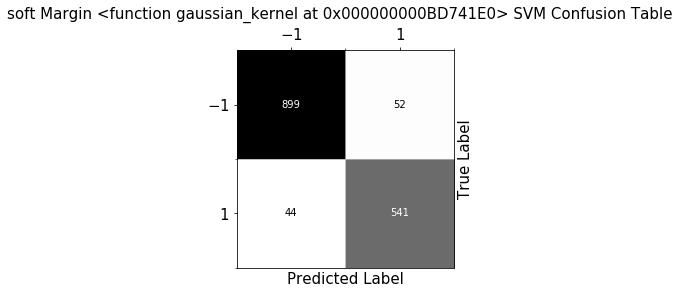

OVERALL TIME FOR FIT: 0.0h:1.0m:51.82640s
DATA DIMENSIONALITY: 2-D
TRAIN ACCURACY: 94.40% | TRAIN ERROR RATE: 5.60%
  TRAIN FALSE NEGATIVES: 2.90% | TRAIN FALSE POSTIVES: 2.70%
TEST ACCURACY: 93.75% | TEST ERROR RATE: 6.25%
  TEST FALSE NEGATIVES: 2.86% | TEST FALSE POSTIVES: 3.39%


In [157]:
print("Would You Like to Perform Evaluation? (y/n)")
USER_I = input()
if(USER_I in ('yes', 'Yes', 'Y', 'y')):
    # Set the Dataset Args
    filename, data_set, lab_set = 'eval.mat', 'eval_data', 'eval_label'
    print("Please Indicate if The Evaluation Dataset Args Are Correct? (y/n)")
    print("Filename:{} | Data Set:{} | Label Set:{}".format(filename, data_set, lab_set))
    USER_I = input()
    if(USER_I not in ('yes', 'Yes', 'Y', 'y')):
        print("Please Enter Filename")
        filename = input()
        print("Please Enter Data Set Variable Name")
        data_set = input()
        print("Please Enter Label Set Variable Name")
        lab_set = input()
    
    # Get the Dataset
    EMAIL_EVAL_DICT = scipy.io.loadmat(filename)
    X_EVAL = np.array(EMAIL_EVAL_DICT[data_set]).T
    T_EVAL = np.array(EMAIL_EVAL_DICT[lab_set])
    T_EVAL = T_EVAL.reshape(T_EVAL.shape[0])
    print(">>>>>> EMAIL EVAL DATASET FEATURE SPACE <<<<<<")
    print(X_EVAL.shape)
    print(T_EVAL.shape)
    
    # Preprocess the Dataset
    X_TRAIN_LOG = log_transform(X_TRAIN)
    X_EVAL_LOG = log_transform(X_EVAL)

    X_TRAIN_BNY = binary_transform(X_TRAIN)
    X_EVAL_BNY = binary_transform(X_EVAL)

    X_TRAIN_STD = standardize(X_TRAIN)
    X_EVAL_STD = standardize(X_EVAL)
    
    # CONTROL HYPERPARAMETERS SOFT MARGIN GAUSSIAN KERNEL
    X_train_list = [X_TRAIN_BNY, X_TRAIN_STD, X_TRAIN_LOG]
    X_train_list_names = ['X_TRAIN_BNY', 'X_TRAIN_STD', 'X_TRAIN_LOG']
    X_eval_list = [X_EVAL_BNY, X_EVAL_STD, X_EVAL_LOG]
    Transform_list = ['None', 'PCA', 'LDA']
    Dims_list = [57, 15, 2]
    
    # RUN
    for idx, (X_train, X_eval, transform, dims) in enumerate(zip(X_train_list, X_eval_list, Transform_list, Dims_list)):
        print("\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        print("X_train = {}".format(X_train_list_names[idx]))
        print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
        fit_SVM(X_train, T_TRAIN.astype(float), X_eval, T_EVAL.astype(float),
                kernel = gaussian_kernel, margin_type = 'soft', C=1.1, transform = transform, pp_dims = dims)